In [1]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np

# Constants

In [2]:
sample_rate = 44100
hop_size = 441*2
hidden_mod = 3
maximum = 32
width = 4
ds_path = './datasets/VN/ds.pkl'
model_path = './models/VN/model02_'

# Data Class

In [3]:
import os
import re
import json
import math
import cv2
import subprocess as sp
from osr2mp4.EEnum.EReplay import Replays
from osr2mp4.osr2mp4 import Osr2mp4
import torch
import torchvision.io as vision
import torchvision.transforms as transforms

In [4]:
class OSR():
    def __init__(self, beatmap_dir, beatmap, sample_rate=44100, hop_size=441, skin=None,
                 width=4,
                 tmp='./tmp', vtmp='./vid', atmp='./wav'):
        self.beatmap = beatmap
        self.beatmap_dir = beatmap_dir
        self.beatmap_path = os.path.join(self.beatmap_dir, self.beatmap)
        self.sample_rate = sample_rate
        self.hop_size = hop_size
        self.rate = int(sample_rate / hop_size)
        self.fps = self.rate
        self.tmp = tmp
        self.vtmp = vtmp
        self.atmp = atmp
        self.width = 4
        self.skin = skin
        self.data_json = os.path.join(self.tmp, self.beatmap + '.json')
        self.video_path = os.path.join(self.vtmp, self.beatmap + '.avi')
        
        self.replay_info = None
        self.osr2mp4 = None
        self.video = None
        self.hitobjects = None
        self.cursorstream = None
        self.timestamp = None
                
    def run_osr2mp4(self):
        d = json.load(open('data.json', 'r'))
        f = open(self.data_json, 'w')
        d['Beatmap path'] = self.beatmap_path
        if self.skin is not None:
            d['Skin path'] = self.skin
        d['FPS'] = self.fps
        d['Output path'] = self.video_path
        json.dump(d, f)
        f.close()
                 
        self.osr2mp4 = Osr2mp4(filedata=self.data_json, filesettings='settings.json', filepp='ppsettings.json', 
                               filestrain='strainsettings.json', logtofile=True)
        while True:
            if self.osr2mp4.replay_info.play_data[-1][Replays.CURSOR_X] == 0 and self.osr2mp4.replay_info.play_data[-1][Replays.CURSOR_Y] == 0:
                self.osr2mp4.replay_info.play_data = self.osr2mp4.replay_info.play_data[0:-1]
            else:
                break
        
    def create_vid(self):
        if self.osr2mp4 is None:
            self.run_osr2mp4()
        cmd = ['python', 'create_vid.py', self.data_json]
        proc = sp.Popen(cmd)
        proc.wait()
        
    def parse_timings(self):
        if self.video is None:
            self.get_video()
        self.beat_len = []
        self.timestamp = []
        f = open(self.beatmap_path)
        for l in f:
            if re.match(r'BeatDivisor.*', l):
                self.BeatDivisor = int(l.split(':')[1])
                break
        f.seek(0)
        for l in f:
            if re.match(r'\[TimingPoints\]', l):
                break
        for l in f:
            if l == "\n":
                break
            a = l.split(',')
            if float(a[1]) < 0:
                continue
            self.beat_len.append(float(a[1]))
            self.timestamp.append(float(a[0]))
        self.timestamp.append(int(self.video[1].shape[1] / self.video[2]['audio_fps'] * 1000))
        f.close()
    
    def parse_hitobjects(self):
        self.hitobjects = []
        f = open(self.beatmap_path)
        for l in f:
            if re.match(r'ApproachRate.*', l):
                AR = float(l.split(':')[1])
                if AR < 5.0:
                    preempt = 1200 + 600 * (5 - AR) / 5
                    fadein = 800 + 400 * (5 - AR) / 5
                else:
                    preempt = 1200 - 750 * (AR - 5) / 5
                    fadein = 800 - 500 * (AR - 5) / 5
                self.preempt = preempt - fadein*0.1
                break
        f.seek(0)
        for l in f:
            if re.match(r'SliderMultiplier.*', l):
                self.sliderMultiplier = float(l.split(':')[1])
                break
        f.seek(0)
        for l in f:
            if re.match(r'\[HitObjects\]', l):
                break
        for l in f:
            self.hitobjects.append(l.split(','))
        f.close()
    
    def parse_beatmap(self):
        self.parse_timings()
        self.parse_hitobjects()
        
    def create_cursor_peak(self, y, i):
        alen = len(y)
        w = self.width/2/2
        
        def func(x):
            return math.exp(-j**2/w**2)
        
        j = 0 
        while i+j > 0 and abs(j) <= w*2:
            f = func(j)
            y[i+j][Replays.KEYS_PRESSED] = max(y[i+j][Replays.KEYS_PRESSED], f, 0)
            j -= 1
        j = 0
        while i+j < alen and abs(j) <= w*2:
            f = func(j)
            y[i+j][Replays.KEYS_PRESSED] = max(y[i+j][Replays.KEYS_PRESSED], f, 0)
            j += 1
    
    def process_beatobjects(self):
        pass
    
    def process_hitobjects(self):
        if self.hitobjects is None:
               self.parse_beatmap()
        self.hitobjStream = [None] * math.ceil(self.timestamp[-1] * 0.001 * self.rate)
    
    def process_clicks(self):
        pass
    
    def process_cursor(self):
        if self.osr2mp4 is None:
            self.run_osr2mp4()
        n = math.ceil((self.osr2mp4.replay_info.play_data[-1][Replays.TIMES] - self.get_offset()) * 0.001 * self.fps)
        self.cursorstream = [None] * n
        #self.cursorstream = np.zeros((n, 3))
        
        for j in range(len(self.osr2mp4.replay_info.play_data) - 1):
            a = self.osr2mp4.replay_info.play_data[j]
            b = self.osr2mp4.replay_info.play_data[j+1]
            delta = (b[Replays.TIMES] - a[Replays.TIMES]) * 0.001 * self.fps
            xdist = b[Replays.CURSOR_X] - a[Replays.CURSOR_X]
            ydist = b[Replays.CURSOR_Y] - a[Replays.CURSOR_Y]
            stime = (a[Replays.TIMES] - self.get_offset()) * 0.001 * self.fps
            x = a[Replays.CURSOR_X]
            y = a[Replays.CURSOR_Y]
            
            e = np.array([0.0, 0.0, 0])           
            for t in range(math.ceil(delta)):
                e[Replays.CURSOR_X] = x + xdist/delta*t
                e[Replays.CURSOR_Y] = y + ydist/delta*t
                self.cursorstream[int(stime + t)] = torch.tensor(e, dtype=torch.float)
            e[Replays.KEYS_PRESSED] = a[Replays.KEYS_PRESSED]
            e[Replays.CURSOR_X] = a[Replays.CURSOR_X]
            e[Replays.CURSOR_Y] = a[Replays.CURSOR_Y]
            self.cursorstream[int((a[Replays.TIMES] - self.get_offset()) * 0.001 * self.fps)] = torch.tensor(e, dtype=torch.float)
            e[Replays.KEYS_PRESSED] = b[Replays.KEYS_PRESSED]
            e[Replays.CURSOR_X] = b[Replays.CURSOR_X]
            e[Replays.CURSOR_Y] = b[Replays.CURSOR_Y]
            self.cursorstream[int((b[Replays.TIMES] - self.get_offset()) * 0.001 * self.fps)] = torch.tensor(e, dtype=torch.float)
        
        for i in range(len(self.cursorstream)):
            if self.cursorstream[i] is None:
                self.cursorstream[i] = torch.tensor([0.0, 0.0, 0])
        r = copy.deepcopy(self.cursorstream)
        for i in range(len(self.cursorstream)):
            if r[i][Replays.KEYS_PRESSED] != 0:
                self.create_cursor_peak(self.cursorstream, i)
        #for i in range(len(self.cursorstream)):
        #    self.cursorstream[i] = torch.tensor(self.cursorstream[i])
        
    def process_events(self):
        self.process_clicks()
        self.process_cursor()
        
    def read_video(self, scale=1):
        if not os.path.exists(self.video_path):
            self.create_vid()
        #self.video = vision.read_video(self.video_path)
        transform = transforms.ToTensor()
        frames = []
        vc = cv2.VideoCapture(self.video_path)
        while True:
            r, f = vc.read()
            f = cv2.resize(f, (0,0), fx=scale, fy=scale)
            frames.append(transform(f))
            if r is False:
                break
        return torch.stack(frames)
        
    def queue_vid(self):
        if not os.path.exists(self.video_path):
            self.create_vid()   
        return self.video_path
    
    def get_offset(self):
        if self.osr2mp4 is None:
            self.run_osr2mp4()
        return self.osr2mp4.replay_info.play_data[0][Replays.TIMES]
    
    def get_beatobjects(self):
        if self.beatobjStream is None:
            self.process_beatobjects()
        stream = [None] * len(self.beatobjStream)
        for i in range(len(self.beatobjStream)):
            if self.beatobjStream[i] == [] or self.beatobjStream == None:
                h = np.array([0], dtype=np.float32)
            else:
                h = np.array(self.beatobjStream[i], dtype=np.float32)
            stream[i] = torch.tensor(np.pad(h, (0, 64 - h.shape[0])))
        return torch.stack(stream)
        
    def get_hitobjects(self):
        if self.hitobjStream is None:
            self.process_hitobjects()
        stream = [None] * len(self.hitobjStream)
        for i in range(len(self.hitobjStream)):
            if self.hitobjStream[i] == [] or self.hitobjStream == None:
                h = np.array([0], dtype=np.float32)
            else:
                h = np.array(self.hitobjStream[i], dtype=np.float32)
            stream[i] = torch.tensor(np.pad(h, (0, 64 - h.shape[0])))
        return torch.stack(stream)
    
    def get_cursor(self):
        if self.cursorstream is None:
            self.process_events()
        return torch.stack(self.cursorstream)
        
    def get_video(self, scale=1):
        if self.video is None:
            self.read_video(scale=1)
        return self.video

# Dataset

In [5]:
import glob
import copy
import traceback
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import cv2
import matplotlib.pyplot as plt

In [6]:
class OSR_Dataset(Dataset):
    def __init__(self, beatmap_dir, sample_rate=44100, hop_size=441, seq_dur=10, scale=1, hidden_mod=0, maximum=100):
        self.beatmap_dir = beatmap_dir
        self.sample_rate = sample_rate
        self.hop_size = hop_size
        self.seq_len = int(seq_dur * sample_rate / hop_size)
        self.hidden_mod = hidden_mod
        self.maximum = maximum
        self.scale = scale
        
        self.osrs = []
        
        if beatmap_dir is None:
            self.v = []
            self.c = []
            return
        
        j = 0
        def parse_beatmaps(j):
            for r, dirs, _ in os.walk(beatmap_dir):
                for dir in dirs:
                    for root, _, files in os.walk(os.path.join(r, dir)):
                        for f in files:
                            if re.match(r'.*osu$', f):
                                if self.hidden_mod == 0 or j % self.hidden_mod != 0:
                                    self.osrs.append(OSR(root, f, sample_rate=sample_rate, hop_size=hop_size))
                                else:
                                    self.osrs.append(OSR(root, f, sample_rate=sample_rate, hop_size=hop_size, skin='./skin_hidden'))
                                if j == self.maximum:
                                    return j
                                j += 1
            return j
        j = parse_beatmaps(j)
        
        self.v = [None] * j
        self.c = [None] * j
        
        def process(i):
            m = self.osrs[i]
            self.osrs[i] = None;
            try:
                print(str(i) + '/' + str(j-1), m.beatmap)
                self.v[i] = copy.deepcopy(m.queue_vid())
                self.c[i] = copy.deepcopy(m.get_cursor())
            except Exception as e:
                traceback.print_exc()
                print("pruning:", m.beatmap)
                self.v[i] = None
                self.c[i] = None
            del m
        
        list(map(process, range(j)))
        
    def take(self, ds, i, j):
        self.v = ds.v[i:j]
        self.c = ds.c[i:j]

    def __len__(self):
        return len(self.v)

    def __getitem__(self, i):
        if self.seq_len == 0:
            return None
        
        transform = transforms.ToTensor()
        j = np.random.randint(0, self.c[i].shape[0] - self.seq_len)
        vc = cv2.VideoCapture(self.v[i])
        vc.set(cv2.CAP_PROP_POS_FRAMES, j)
        #for k in range(j):
        #    _, _ = vc.read()
        
        f = [None] * self.seq_len
        for k in range(self.seq_len):
            frame = vc.read()[1]
            frame = cv2.resize(frame, (0,0), fx=self.scale, fy=self.scale)
            f[k] = transform(frame)
        
        c = self.c[i][j: j+self.seq_len]
        cy = torch.div(c[:,Replays.CURSOR_Y], 384) #, dtype=c.type())
        c[:,1] = torch.div(c[:,Replays.CURSOR_X], 512) #, dtype=c.type())
        c[:,0] = cy
        
        return (torch.stack(f), c) #self.c[i][j: j+self.seq_len])

# Testing

In [6]:
s = OSR_Dataset('../ex/beatmaps', sample_rate=44100, hop_size=441*2, hidden_mod=0, maximum=1)

0/0 sasakure.UK - Spider Thread Monopoly feat. Hatsune Miku (Mishima Yurara) [Milan-'s Hard].osu


(600, 1024, 3)
tensor(0.4718, dtype=torch.float64) tensor(0.4639, dtype=torch.float64)
(242, 142)


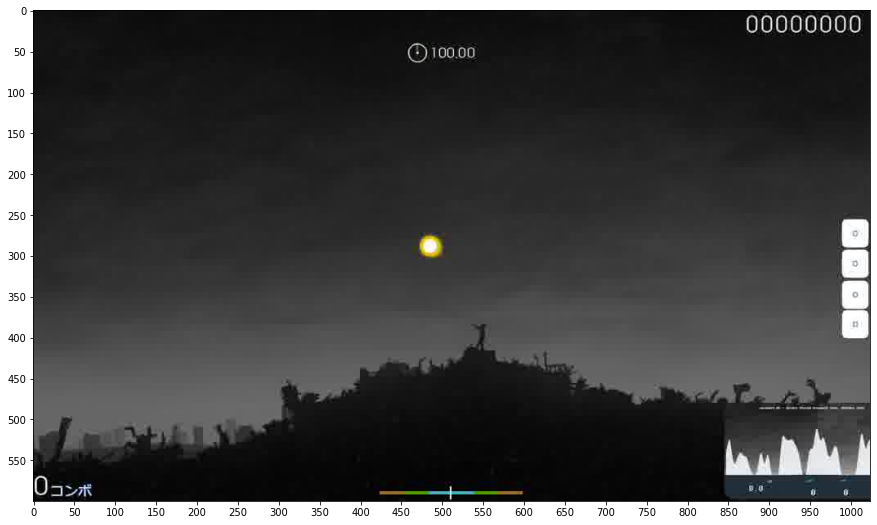

In [7]:
import matplotlib.pyplot as plt

import op

op.h = 600 / 2
op.w = 1024 / 2
op.calratio()

e = s[0]
print(e[0][0].permute(1, 2, 0).numpy().shape)

plt.rcParams["figure.figsize"] = (15, 15)

plt.xticks(np.arange(0, e[0][0].permute(1, 2, 0).numpy().shape[1], 50))
plt.yticks(np.arange(0, e[0][0].permute(1, 2, 0).numpy().shape[0], 50))

plt.imshow(cv2.cvtColor(e[0][0].permute(1, 2, 0).numpy(), cv2.COLOR_BGR2RGB))
print(e[1][0][1], e[1][0][0])
print(op.cor(e[1][0][1] * 512, e[1][0][0] * 384))
#print(op.cor(e[1][0][1], e[1][0][0]))
#for x in e[1][0:10]:
    #print(op.cor(x[0], x[1]))

# Process Data

In [55]:
import time

In [35]:
ds = OSR_Dataset('../beatmaps', sample_rate=sample_rate, hop_size=hop_size, hidden_mod=hidden_mod, maximum=maximum)

0/31 Chata - Engage (Lasse) [Insane].osu
1/31 Mimi - Surrealism (feat. ZAT) (-Tatsuo) [no mania].osu
2/31 sana - kanojo wa tabi ni deru (Firika) [Insane].osu
3/31 Ishida Youko - To the Promised Sky ~The place that I was~ (caren) [Collabo].osu
4/31 StylipS - Prism Sympathy(Asterisk Remix) (iMage--) [Kaleid Liner].osu
5/31 Cranky - Chandelier - King (Mao) [Gero's Insane].osu
6/31 senya - Akatsuki no Suiheisen ni (Satellite) [Zweib's Insane].osu
7/31 Tadokoro Azusa - 1HOPE SNIPER (Sotarks) [NiNo's Insane].osu
8/31 fripSide - future gazer (TV Size) (alacat) [Insane].osu
9/31 cYsmix - bells! (Gero) [normal!].osu
10/31 Yazawa Nico (CV.Tokui Sora) - Nicopuri Joshidou (yf_bmp) [z1085684963's Insane].osu
11/31 Hamburgaga - Watame Internet Connection Race (CE6A) [Insane].osu
12/31 xi - Parousia -LAST JUDGMENT- (Zapy) [Retribution].osu
13/31 Shiena Nishizawa - Meaning (Taeyang) [xChippy's Insane].osu
14/31 namirin - Hitokoto no Kyori (sahuang) [Linadeft's Insane].osu
15/31 Narushima - Gothic and 

In [36]:
start = time.time()

torch.save(ds, ds_path)

end = time.time()
print(end - start, 'secs')

0.01752758026123047 secs


# Load Daaset

In [7]:
ds = torch.load(ds_path)

# Model

In [45]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

from attention.attention import SpatialAttn, ProjectorBlock

In [60]:
class VN(nn.Module):
    def __init__(self, dim_in, device):
        super(VN, self).__init__()
        
        self.device = device
        self.lstmA_size = 32
        self.lstmA_layers = 2
        self.dim_out = 2
        self.att_out = 2
        
        sample_size = 32
        normalize_attn = True

        cA = [0,0]
        W = dim_in[0]
        K = cAK = 1
        P = cAP = 0
        S = cAS = 1
        w = int(((W - K + 2*P)/S) + 1)
        k = mAk = 2
        p = mAp = 0
        s = mAs = 2
        m = int(((w - k + 2*p)/s) + 1)
        cA[0] = w
        
        W = dim_in[1]
        K = cAK
        P = cAP
        S = cAS
        w = int(((W - K + 2*P)/S) + 1)
        k = mAk
        p = mAp
        s = mAs
        m = int(((w - k + 2*p)/s) + 1)
        cA[1] = w
        
        cB = [0,0]
        W = cA[0]
        K = cBK = 4
        P = cBP = 1
        S = cBS = 2
        w = int(((W - K + 2*P)/S) + 1)
        k = mBk = 2
        p = mBp = 0
        s = mBs = 2
        m = int(((w - k + 2*p)/s) + 1)
        cB[0] = w
        
        W = cA[1]
        K = cBK
        P = cBP
        S = cBS
        w = int(((W - K + 2*P)/S) + 1)
        k = mBk
        p = mBp
        s = mBs
        m = int(((w - k + 2*p)/s) + 1)
        cB[1] = w
        
        """
        self.convA = nn.Conv3d(1, 1, (3, cAK, cAK), stride=cAS, padding=cAP)
        self.maxPA = nn.MaxPool2d(mAk, stride=mAs, padding=mAp)
        self.convB = nn.Conv2d(1, 1, cBK, stride=cBS, padding=cBP) 
        self.maxPB = nn.MaxPool2d(mBk, stride=mBs, padding=mBp)
        """
        """
        self.projb = nn.Conv2d(3, 32, 1)
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        #self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        
        self.attention = SpatialAttn(32)
        #self.linear1 = nn.Linear(math.prod(cB)*self.att_out,  int(math.prod(cB)/4*self.att_out))
        """
        self.conv1 = self._make_layer(3, 64, 2)
        self.conv2 = self._make_layer(64, 128, 2)
        self.conv3 = self._make_layer(128, 256, 3)
        self.conv4 = self._make_layer(256, 512, 3)
        self.conv5 = self._make_layer(512, 512, 3)
        self.conv6 = self._make_layer(512, 512, 2, pool=True)
        
        self.dense = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=int(sample_size/32), padding=0, bias=True)

        
        self.projector = ProjectorBlock(256, 512)
        self.attn1 = SpatialAttn(in_features=512, normalize_attn=normalize_attn)
        self.attn2 = SpatialAttn(in_features=512, normalize_attn=normalize_attn)
        self.attn3 = SpatialAttn(in_features=512, normalize_attn=normalize_attn)
            
        #self.lstmA = nn.LSTM(int(math.prod(cB)), hidden_size=self.lstmA_size, num_layers=self.lstmA_layers,
        #                     batch_first=True, bidirectional=False)
        self.lstmA = nn.LSTM(1536, hidden_size=self.lstmA_size, num_layers=self.lstmA_layers,
                             batch_first=True, bidirectional=False)
        self.linearA = nn.Linear(self.lstmA_size, 32)
        self.linearB = nn.Linear(32, self.dim_out)
        
        #self.hiddenA = None
        
    def _make_layer(self, in_features, out_features, blocks, pool=False):
        layers = []
        for i in range(blocks):
            conv2d = nn.Conv2d(in_channels=in_features, out_channels=out_features, kernel_size=3, padding=1, bias=False)
            layers += [conv2d, nn.BatchNorm2d(out_features), nn.ReLU(inplace=True)]
            in_features = out_features
            if pool:
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        return nn.Sequential(*layers)
        
    def init_hidden(self, batch_size):
        h = torch.zeros(self.lstmA_layers, batch_size, self.lstmA_size).to(self.device)
        c = torch.zeros(self.lstmA_layers, batch_size, self.lstmA_size).to(self.device)
        self.hiddenA = (h, c)
 
    def forward(self, x):
        s = x.shape
        x = torch.reshape(x, (s[0] * s[1], s[2], s[3], s[4]))
        """
        x = x.unsqueeze(1)
        x = self.convA(x)
        x = nnF.relu(x)
        #x = self.maxPA(x)
        x = x.squeeze(1)
        l = self.convB(x)
        l = nnF.relu(l)
        x = self.maxPB(x)
        
        l = x
        l = nnF.max_pool2d(l, 2, 2)
        l = self.projb(l)
        
        x = self.conv1(x)
        x = nnF.max_pool2d(x, 2, 2)
        x = self.conv2(x)
        #x = nnF.max_pool2d(x, 2, 2)
        #x = self.conv3(x)
        g = x
        
        c, g = self.attention(l, g)
        x = g
        """
        
        x = self.conv1(x)
        x = self.conv2(x)
        l1 = self.conv3(x)
        x = F.max_pool2d(l1, kernel_size=2, stride=2, padding=0)
        l2 = self.conv4(x)
        x = F.max_pool2d(l2, kernel_size=2, stride=2, padding=0)
        l3 = self.conv5(x)
        x = F.max_pool2d(l3, kernel_size=2, stride=2, padding=0)
        x = self.conv6(x)
        g = self.dense(x) 
        
        p = self.projector(l1)
        print(l1.shape, g.shape)
        c1, g1 = self.attn1(p, g)
        c2, g2 = self.attn2(l2, g)
        c3, g3 = self.attn3(l3, g)
        g = torch.cat((g1,g2,g3), dim=1) 

        x = g
        
        x = torch.flatten(x, start_dim=1)
        x = torch.reshape(x, (s[0], s[1], x.shape[-1]))
           
        #x = self.linear1(x)
        #x = nnF.relu(x)
        
        x, self.hiddenA = self.lstmA(x, self.hiddenA)
        x = self.linearA(x)
        x = nnF.relu(x)
        x = self.linearB(x)
        
        return x

# Training

In [61]:
import torch
from torch.utils.data import DataLoader
from torchinfo import summary
from qqdm.notebook import qqdm
import matplotlib.pyplot as plt
import op

In [62]:
batch_size = 1
scale = 1/4
dim_in = (int(600 * scale), int(1024 * scale))
seq_dur = 2

In [63]:
device = torch.device('cuda')

In [64]:
epoch_cum = 0
val_hist = []
train_hist = []
vn = VN(dim_in=dim_in, device=device)
vn.to(device)

VN(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): B

In [65]:
vn.init_hidden(1)
#summary(vn, input_size=(1, 1, 3, dim_in[0], dim_in[1]), col_width=16,
summary(vn, input_size=(1, 1, 3, 32, 32), col_width=16,
           col_names=["input_size",
                "output_size",
                "num_params",
                "kernel_size",
                "mult_adds",])

torch.Size([1, 256, 32, 32]) torch.Size([1, 512, 1, 1])


Layer (type:depth-idx)                   Input Shape      Output Shape     Param #          Kernel Shape     Mult-Adds
VN                                       --               --               --               --               --
├─Sequential: 1-1                        [1, 3, 32, 32]   [1, 64, 32, 32]  --               --               --
│    └─Conv2d: 2-1                       [1, 3, 32, 32]   [1, 64, 32, 32]  1,728            [3, 64, 3, 3]    1,769,472
│    └─BatchNorm2d: 2-2                  [1, 64, 32, 32]  [1, 64, 32, 32]  128              [64]             128
│    └─ReLU: 2-3                         [1, 64, 32, 32]  [1, 64, 32, 32]  --               --               --
│    └─Conv2d: 2-4                       [1, 64, 32, 32]  [1, 64, 32, 32]  36,864           [64, 64, 3, 3]   37,748,736
│    └─BatchNorm2d: 2-5                  [1, 64, 32, 32]  [1, 64, 32, 32]  128              [64]             128
│    └─ReLU: 2-6                         [1, 64, 32, 32]  [1, 64, 32, 32]  --   

In [15]:
train_ds = OSR_Dataset(None, sample_rate=sample_rate, hop_size=hop_size, seq_dur=seq_dur, scale=scale, hidden_mod=hidden_mod, maximum=maximum)
val_ds = OSR_Dataset(None, sample_rate=sample_rate, hop_size=hop_size, seq_dur=seq_dur, scale=scale, hidden_mod=hidden_mod, maximum=maximum)

train_ds.take(ds, 0, int(len(ds) * 0.8))
val_ds.take(ds, int(len(ds) * 0.8), len(ds))

train_ldr = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=1, prefetch_factor=2)
val_ldr = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=1, prefetch_factor=2)

In [16]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(vn.parameters(), lr=0.001)

In [17]:
op.h = dim_in[0]
op.w = dim_in[1]
op.calratio()

def trainVN():
    global epoch_cum, lamb
    global v, c, PV, pv, g, gt, MP, MC

    for epoch in range(epochs):
        vn.train()
        train_loss = 0
        info = qqdm(train_ldr)
        for v, c in info:
        #for v, c in train_ldr:
            V, C = v.to(device), c.to(device)
            
            optimizer.zero_grad()
            vn.init_hidden(v.shape[0])
            PV = vn(V)
            
            mp = PV.cpu()
            mc = c
            for i in range(c.shape[0]):
                for j in range(c.shape[1]):
                    xc = c[i][j][2]
                    mc[i][j] = torch.tensor([c[i][j][0]*xc, c[i][j][1]*xc, c[i][j][2]])
                    mp[i][j] = torch.tensor([mp[i][j][0]*xc, mp[i][j][1]*xc])

            loss1 = criterion(PV, C[:,:,:2])
            loss2 = criterion(mp, mc[:,:,:2])
            loss = loss1 + loss2 * lamb
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            info.set_infos({'loss': f'{loss.item():.4f}'})

        vn.eval()
        torch.no_grad()
        val_loss = 0
        for v, c in val_ldr:
            V, C = v.to(device), c.to(device)

            vn.init_hidden(v.shape[0])
            PV = vn(V)
            
            loss1 = criterion(PV, C[:,:,:2])
            loss2 = criterion(mp, mc[:,:,:2])
            loss = loss1 + loss2 * lamb
            val_loss += loss.item()

        print(epoch+epoch_cum, 'of', epochs+epoch_cum)

        plt.rcParams["figure.figsize"] = (15, 5)
        plt.figure()
        _, p = plt.subplots(1, 3)
        
        e = v[0][10].permute(1, 2, 0).numpy()
        g = c[0][10][:2]
        print('pred:', float(PV[0][0][1]), float(PV[0][0][0]))
        print('gt:', float(g[1]), float(g[0]))
        print(op.cor(g[1] * 512, g[0] * 384))
        p[0].imshow(cv2.cvtColor(e, cv2.COLOR_BGR2RGB))
        
        pv = PV[0].cpu().detach().numpy().transpose(1, 0)
        p[1].plot(pv[0], pv[1])
        gt = c[0].permute(1, 0).numpy()
        p[1].plot(gt[0], gt[1])
        
        train_loss = train_loss/len(train_ldr)
        val_loss = val_loss/len(val_ldr)
        train_hist.append(float(train_loss))
        val_hist.append(float(val_loss))
        
        p[2].plot(train_hist)
        p[2].plot(val_hist)
        
        plt.show()

    epoch_cum += epochs

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:03<00:00:00  6.42it/s  0.3744                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

72 of 96
pred: 0.4900781512260437 0.5258052349090576
gt: 0.5050123929977417 0.6056930422782898
(126, 88)


<Figure size 1080x360 with 0 Axes>

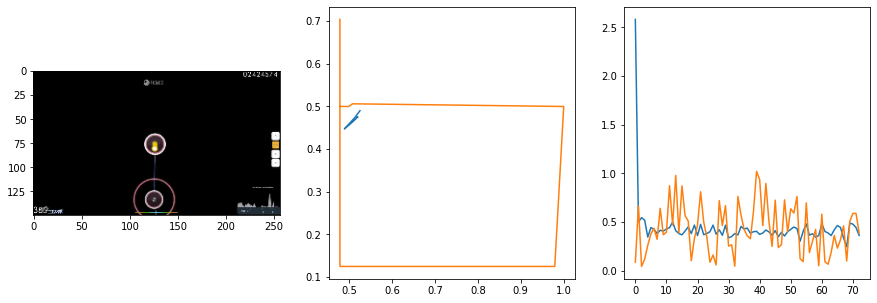

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:03<00:00:00  6.39it/s  0.3042                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

73 of 96
pred: 0.5007112622261047 0.5320894718170166
gt: 0.15434451401233673 0.6819105744361877
(71, 97)


<Figure size 1080x360 with 0 Axes>

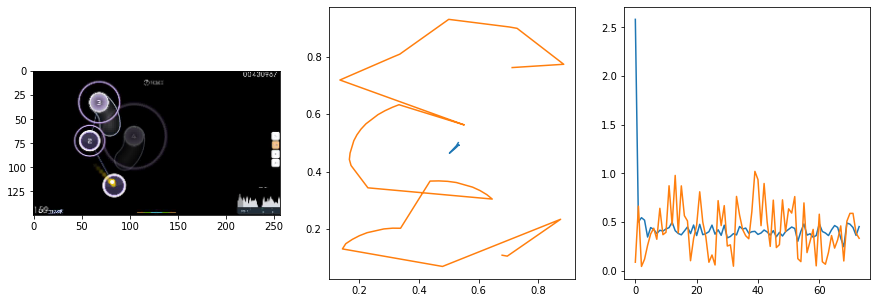

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:03<00:00:00  6.46it/s  0.3768                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

74 of 96
pred: 0.4766579866409302 0.5202401280403137
gt: 0.6278479695320129 0.5722813606262207
(145, 84)


<Figure size 1080x360 with 0 Axes>

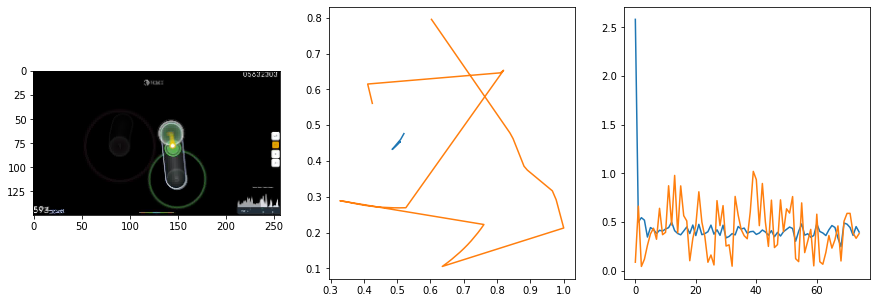

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:03<00:00:00  6.29it/s  0.0486                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

75 of 96
pred: 0.501011312007904 0.5340844392776489
gt: 0.53433758020401 0.3297155797481537
(130, 56)


<Figure size 1080x360 with 0 Axes>

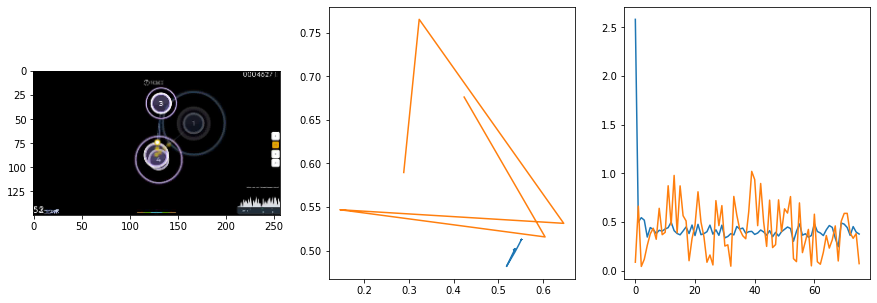

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:03<00:00:00  6.37it/s  0.2890                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

76 of 96
pred: 0.535374641418457 0.5414466261863708
gt: 0.7199317216873169 0.44274795055389404
(159, 69)


<Figure size 1080x360 with 0 Axes>

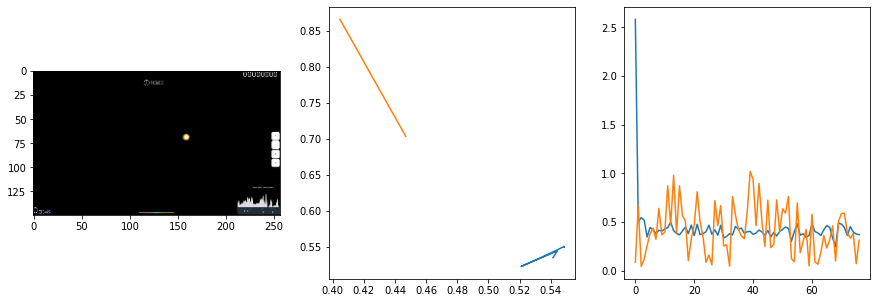

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:03<00:00:00  6.47it/s  0.3911                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

77 of 96
pred: 0.4786026179790497 0.465239018201828
gt: 0.125 0.413833349943161
(67, 66)


<Figure size 1080x360 with 0 Axes>

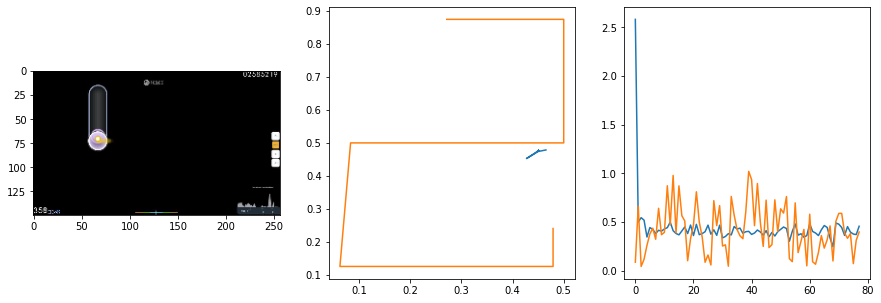

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:03<00:00:00  6.41it/s  0.3952                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

78 of 96
pred: 0.5490654110908508 0.5541664958000183
gt: 0.609375 0.75
(142, 105)


<Figure size 1080x360 with 0 Axes>

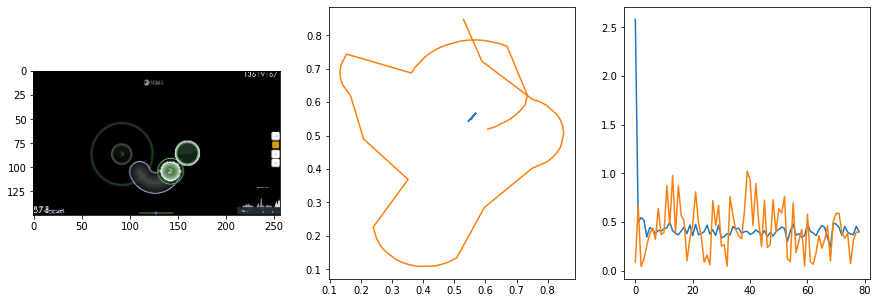

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:03<00:00:00  6.38it/s  0.5219                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

79 of 96
pred: 0.49122074246406555 0.45835691690444946
gt: 0.412109375 0.4738685190677643
(111, 73)


<Figure size 1080x360 with 0 Axes>

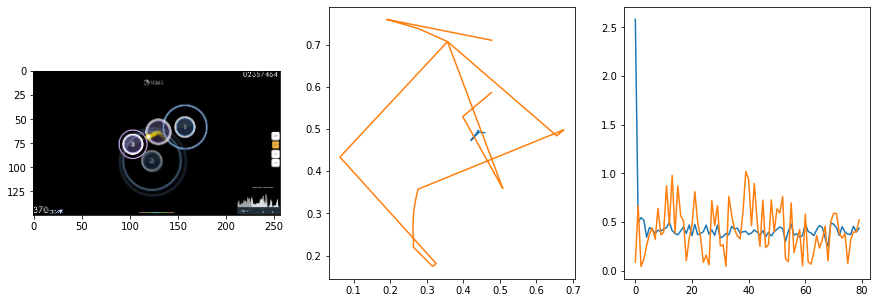

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:03<00:00:00  6.46it/s  0.2275                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

80 of 96
pred: 0.48793095350265503 0.48793888092041016
gt: 0.4549696445465088 0.8271019458770752
(118, 114)


<Figure size 1080x360 with 0 Axes>

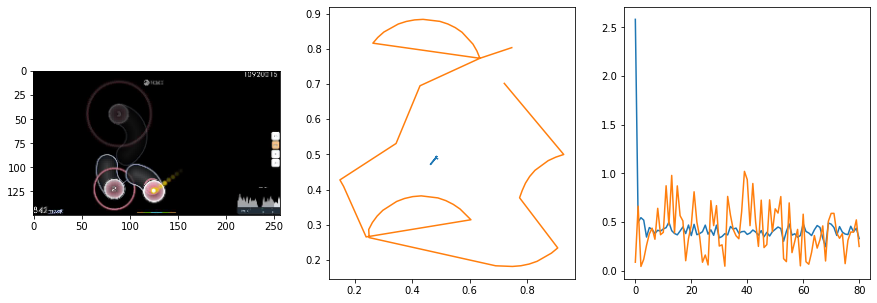

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.22it/s  0.4428                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

81 of 96
pred: 0.5535250902175903 0.5282613039016724
gt: 0.29551300406455994 0.852672278881073
(93, 117)


<Figure size 1080x360 with 0 Axes>

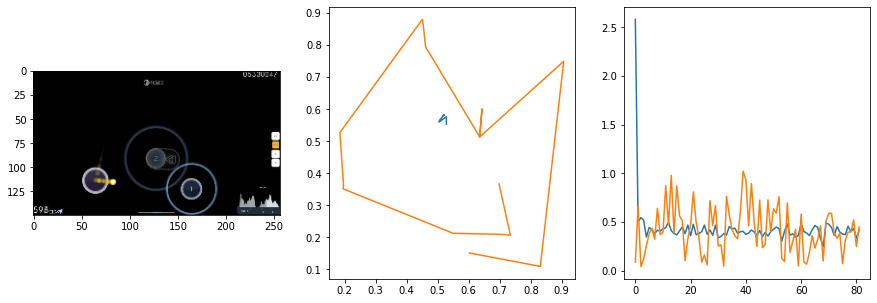

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:03<00:00:00  6.37it/s  0.4146                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

82 of 96
pred: 0.49102282524108887 0.5134363770484924
gt: 0.4996279776096344 0.585069477558136
(125, 86)


<Figure size 1080x360 with 0 Axes>

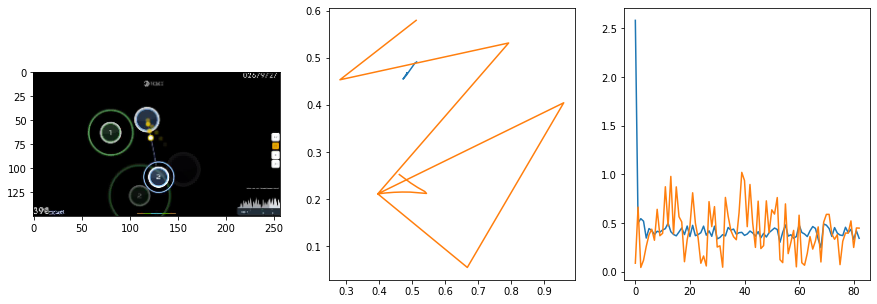

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:03<00:00:00  6.43it/s  0.6324                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

83 of 96
pred: 0.5223227143287659 0.5251135230064392
gt: 0.544921875 0.1354166716337204
(132, 33)


<Figure size 1080x360 with 0 Axes>

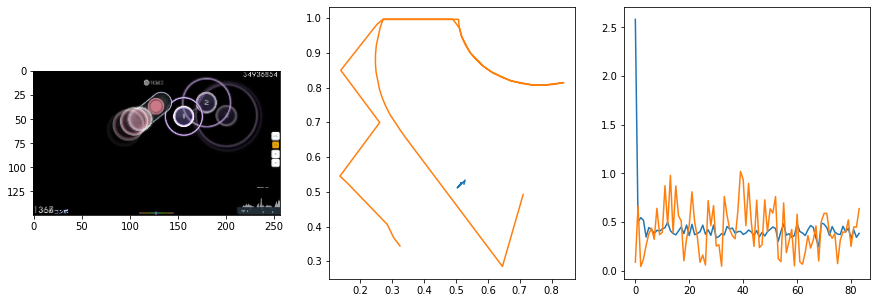

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:03<00:00:00  6.45it/s  0.3028                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

84 of 96
pred: 0.48523736000061035 0.5025039315223694
gt: 0.39588093757629395 0.6114784479141235
(109, 89)


<Figure size 1080x360 with 0 Axes>

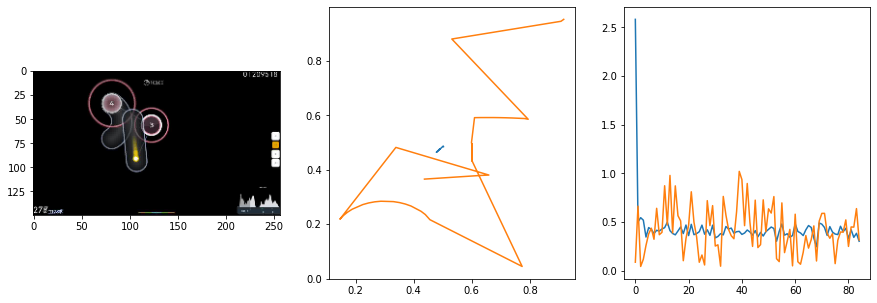

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:03<00:00:00  6.39it/s  0.2308                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

85 of 96
pred: 0.4694381654262543 0.49903473258018494
gt: 0.8517520427703857 0.7063116431236267
(180, 100)


<Figure size 1080x360 with 0 Axes>

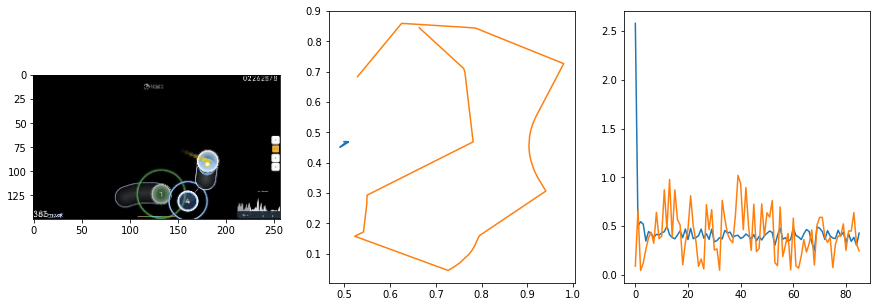

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:03<00:00:00  6.35it/s  0.0075                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

86 of 96
pred: 0.5042014122009277 0.5029832124710083
gt: 0.3599165678024292 0.8667538166046143
(103, 118)


<Figure size 1080x360 with 0 Axes>

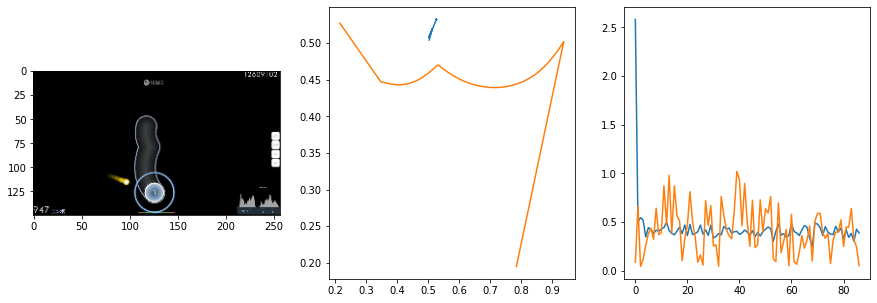

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:03<00:00:00  6.28it/s  0.4544                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

87 of 96
pred: 0.4689728617668152 0.4985278844833374
gt: 0.4181250035762787 0.48625001311302185
(112, 74)


<Figure size 1080x360 with 0 Axes>

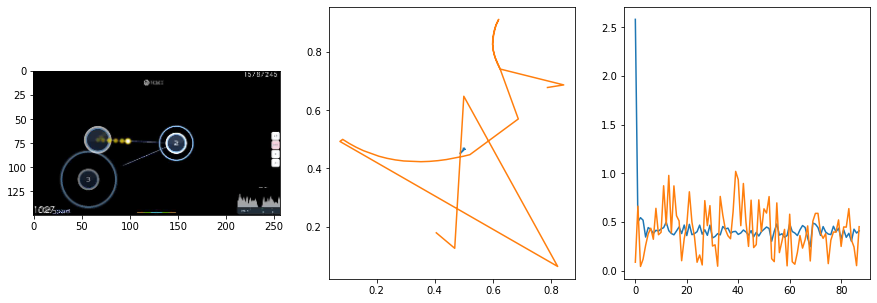

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:03<00:00:00  6.43it/s  0.5808                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

88 of 96
pred: 0.4888972043991089 0.4948676824569702
gt: 0.5510877966880798 0.6809756755828857
(133, 97)


<Figure size 1080x360 with 0 Axes>

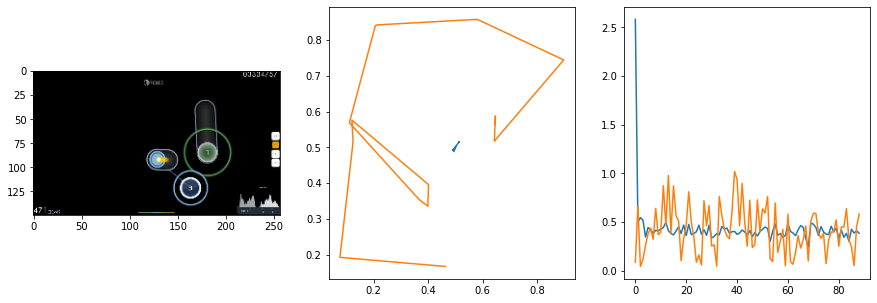

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:03<00:00:00  6.47it/s  0.8047                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

89 of 96
pred: 0.47546619176864624 0.538620114326477
gt: 0.7984325289726257 0.31248894333839417
(171, 54)


<Figure size 1080x360 with 0 Axes>

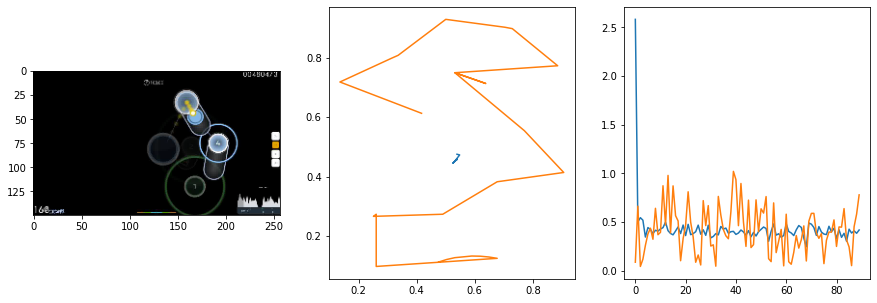

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:03<00:00:00  6.39it/s  0.0148                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

90 of 96
pred: 0.5384758710861206 0.5259792804718018
gt: 0.6488431692123413 0.6690232157707214
(148, 95)


<Figure size 1080x360 with 0 Axes>

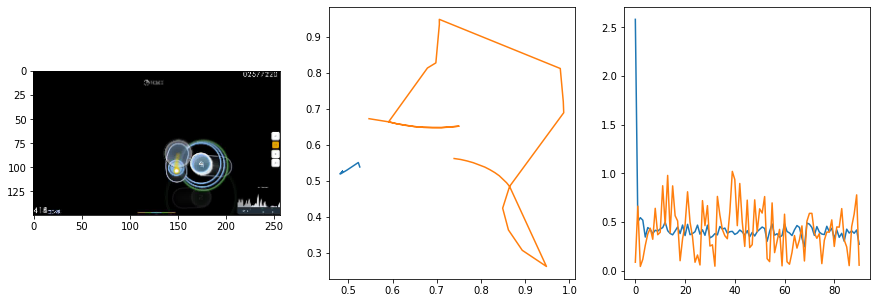

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:03<00:00:00  6.38it/s  0.0035                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

91 of 96
pred: 0.5263051390647888 0.48521000146865845
gt: 0.44458234310150146 0.5827133655548096
(116, 85)


<Figure size 1080x360 with 0 Axes>

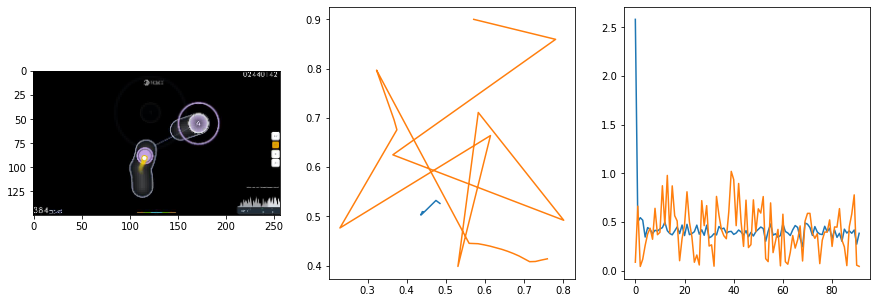

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:04<00:00:00  6.22it/s  0.1562                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

92 of 96
pred: 0.5228041410446167 0.5432947874069214
gt: 0.5 0.7776666283607483
(125, 108)


<Figure size 1080x360 with 0 Axes>

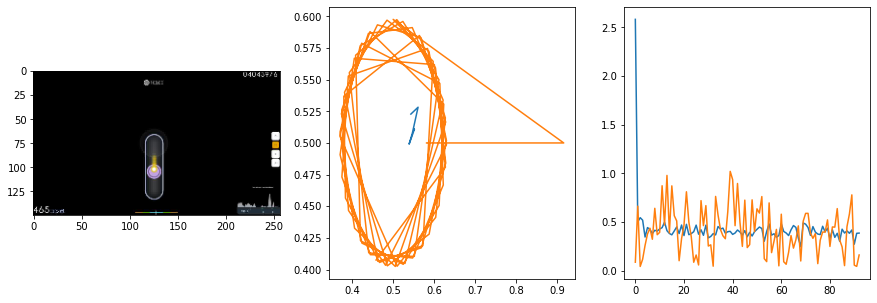

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:03<00:00:00  6.32it/s  0.1785                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

93 of 96
pred: 0.46955564618110657 0.48881280422210693
gt: 0.3164638876914978 0.803800642490387
(97, 111)


<Figure size 1080x360 with 0 Axes>

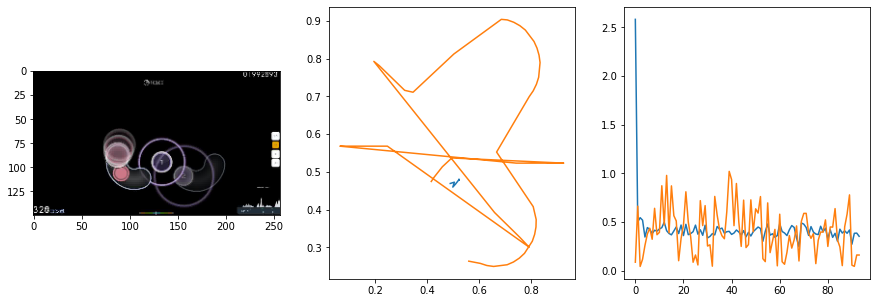

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:03<00:00:00  6.43it/s  0.0297                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

94 of 96
pred: 0.46270379424095154 0.44806531071662903
gt: 0.38255542516708374 0.2576114535331726
(107, 47)


<Figure size 1080x360 with 0 Axes>

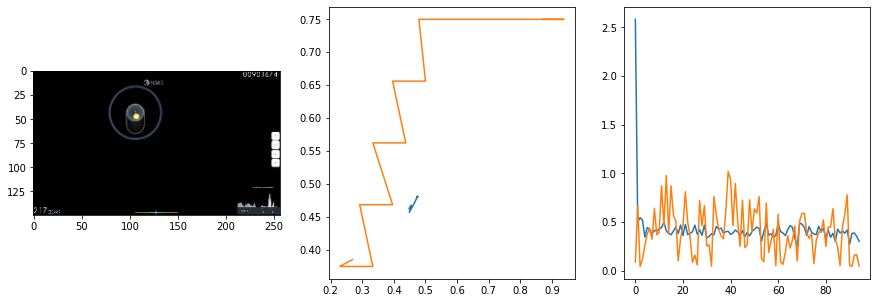

 Iters    Elapsed Time      Speed     loss                                      
 25/25  00:00:03<00:00:00  6.43it/s  0.4144                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

95 of 96
pred: 0.45353958010673523 0.4786047339439392
gt: 0.3419944941997528 0.4434312582015991
(101, 69)


<Figure size 1080x360 with 0 Axes>

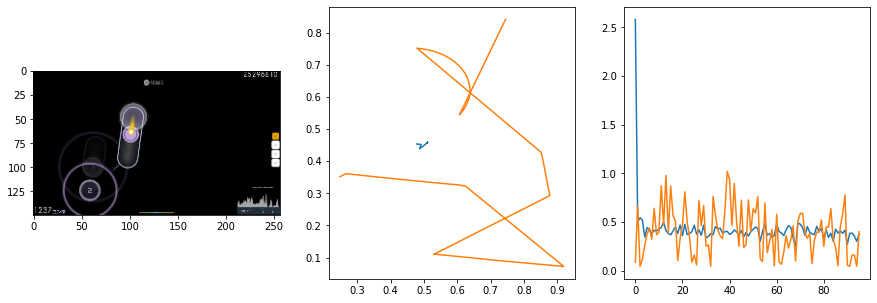

128.22841620445251 secs


In [21]:
start = time.time()

epochs = 24
lamb = 0.2
trainVN()

end = time.time()
print(end - start, 'secs')

In [ ]:
start = time.time()

lamb = 3
epochs = 64
trainVN()

end = time.time()
print(end - start, 'secs')

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.73it/s  0.0116                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

0 of 64
pred: 0.7858656644821167 0.5746828317642212
gt: 0.875 0.23866666853427887
(183, 45)


<Figure size 1080x360 with 0 Axes>

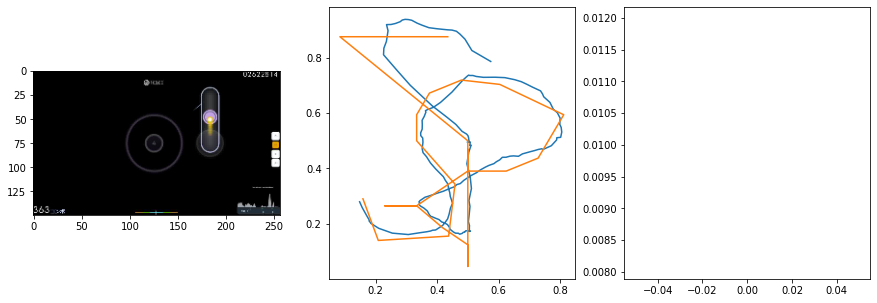

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.71it/s  0.0130                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

1 of 64
pred: 0.418514609336853 0.3419286012649536
gt: 0.515625 0.32600000500679016
(127, 55)


<Figure size 1080x360 with 0 Axes>

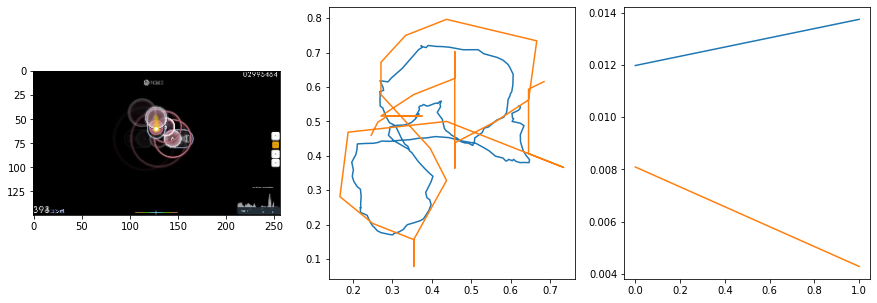

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.73it/s  0.0161                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

2 of 64
pred: 0.6792581081390381 0.6397849917411804
gt: 0.5053117871284485 0.576932430267334
(126, 85)


<Figure size 1080x360 with 0 Axes>

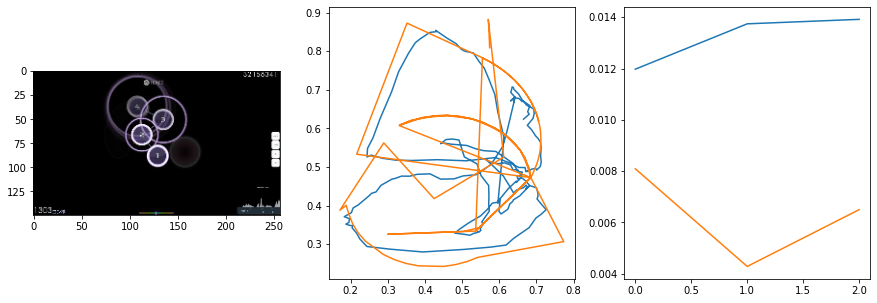

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.74it/s  0.0097                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

3 of 64
pred: 0.25537171959877014 0.4659011960029602
gt: 0.33282068371772766 0.7133352756500244
(99, 100)


<Figure size 1080x360 with 0 Axes>

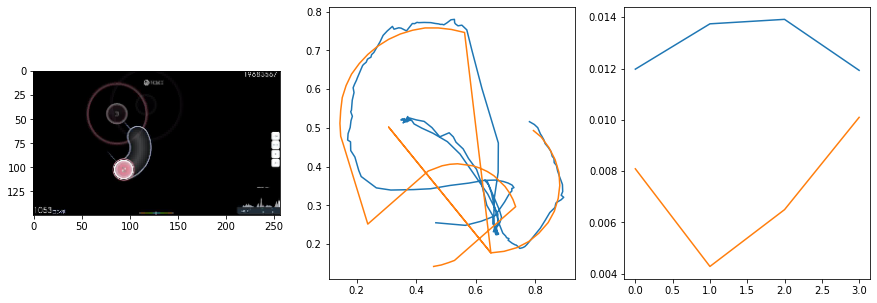

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.76it/s  0.0049                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

4 of 64
pred: 0.45496368408203125 0.45685914158821106
gt: 0.66015625 0.4609375
(150, 71)


<Figure size 1080x360 with 0 Axes>

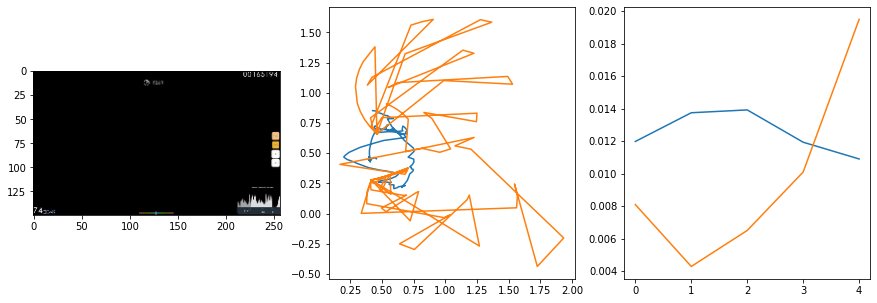

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.70it/s  0.0139                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

5 of 64
pred: 0.6553051471710205 0.7395967245101929
gt: 0.5528242588043213 0.6107361912727356
(133, 89)


<Figure size 1080x360 with 0 Axes>

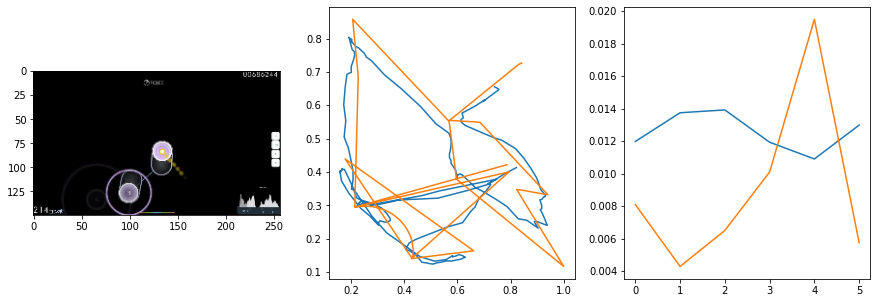

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.80it/s  0.0041                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

6 of 64
pred: 0.4409373104572296 0.44009333848953247
gt: 0.7005208134651184 0.7291666865348816
(156, 102)


<Figure size 1080x360 with 0 Axes>

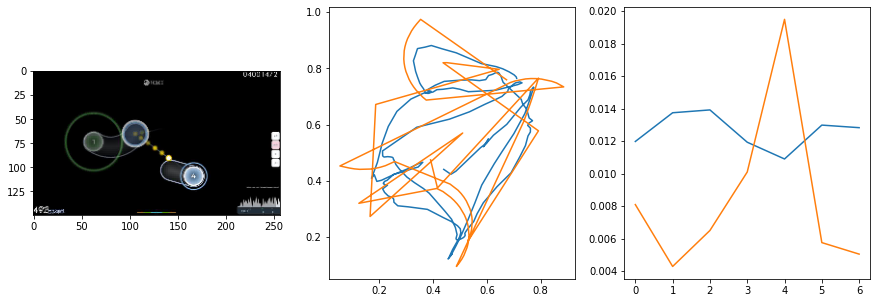

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.78it/s  0.0040                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

7 of 64
pred: 0.6524638533592224 0.5628281831741333
gt: 0.5150168538093567 0.8340818285942078
(127, 115)


<Figure size 1080x360 with 0 Axes>

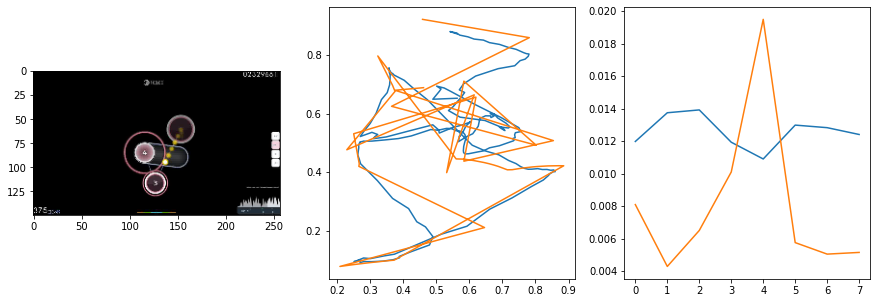

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.76it/s  0.0100                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

8 of 64
pred: 0.6936568021774292 0.29471147060394287
gt: 0.8076030611991882 0.4280634820461273
(173, 67)


<Figure size 1080x360 with 0 Axes>

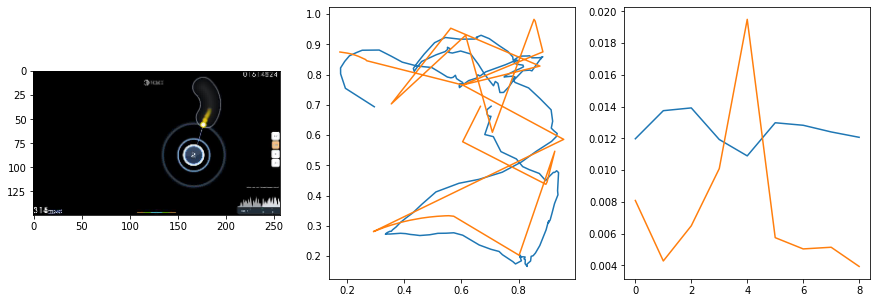

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.73it/s  0.0107                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

9 of 64
pred: 0.6179993152618408 0.5101401805877686
gt: 0.6096088886260986 0.303143709897995
(142, 53)


<Figure size 1080x360 with 0 Axes>

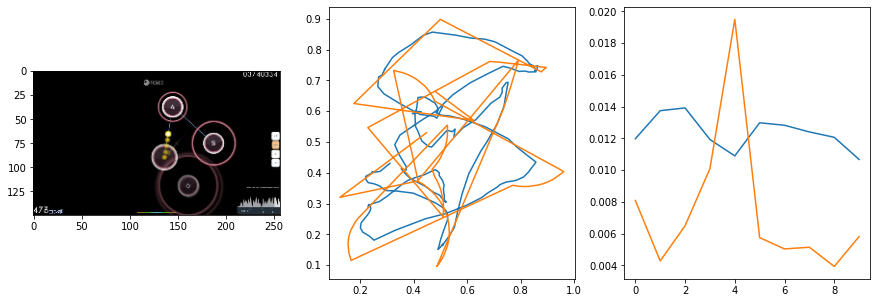

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.75it/s  0.0232                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

10 of 64
pred: 0.5101990103721619 0.2972411513328552
gt: 0.793628454208374 0.20967429876327515
(171, 42)


<Figure size 1080x360 with 0 Axes>

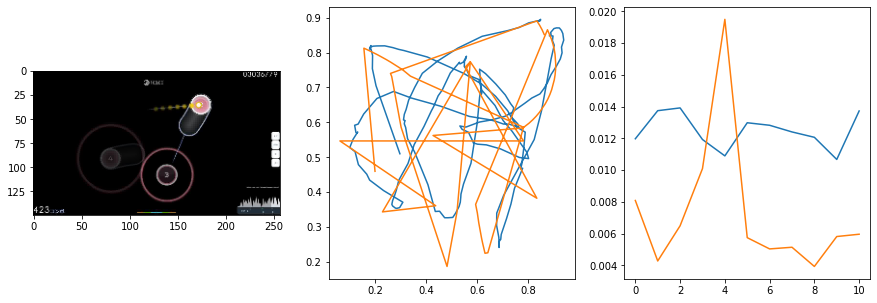

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.70it/s  0.0101                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

11 of 64
pred: 0.25520825386047363 0.25382256507873535
gt: 0.14778228104114532 0.2896956503391266
(70, 51)


<Figure size 1080x360 with 0 Axes>

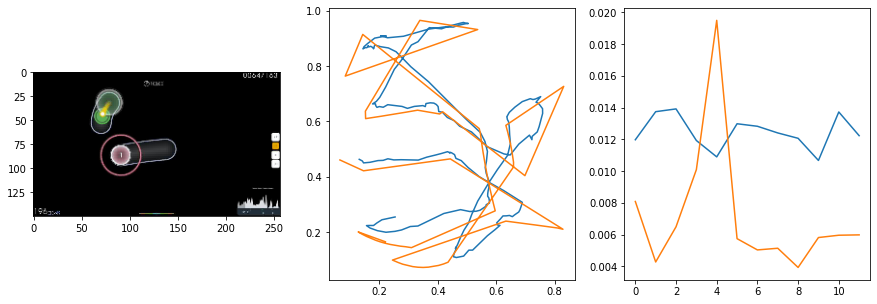

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.74it/s  0.0107                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

12 of 64
pred: 0.7264918684959412 0.5825929641723633
gt: 0.6219785213470459 0.4948361814022064
(144, 75)


<Figure size 1080x360 with 0 Axes>

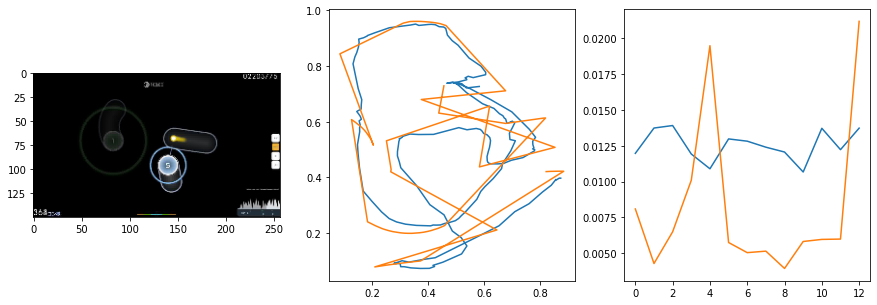

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.74it/s  0.0185                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

13 of 64
pred: 0.44640499353408813 0.5090669989585876
gt: 0.8068886399269104 0.6276074051856995
(173, 90)


<Figure size 1080x360 with 0 Axes>

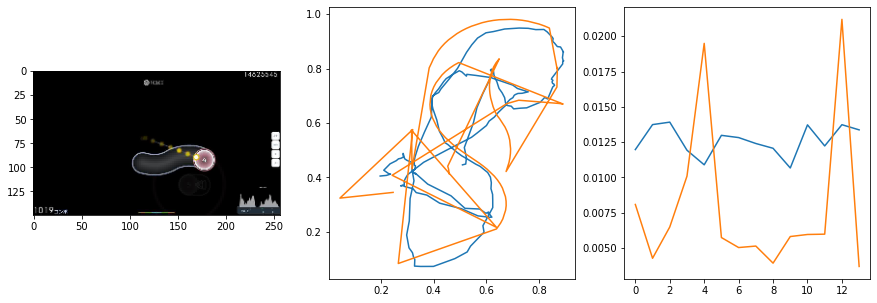

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.73it/s  0.0082                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

14 of 64
pred: 0.29341819882392883 0.6147027611732483
gt: 0.21227961778640747 0.46913233399391174
(80, 72)


<Figure size 1080x360 with 0 Axes>

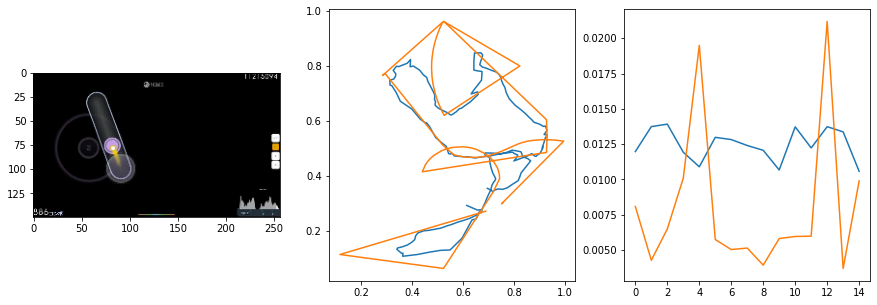

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.80it/s  0.0201                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

15 of 64
pred: 0.7008026242256165 0.4300870895385742
gt: 0.760732889175415 0.3631947338581085
(165, 60)


<Figure size 1080x360 with 0 Axes>

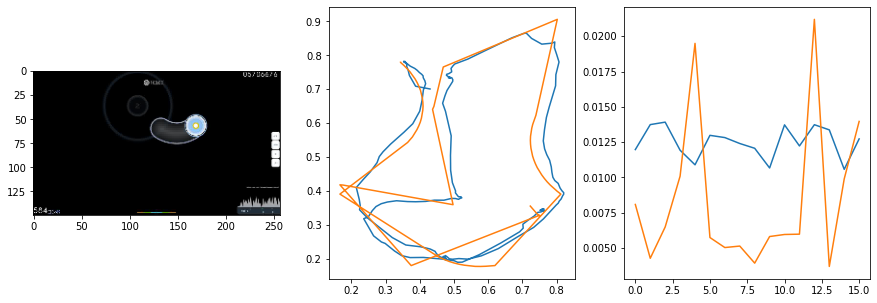

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.74it/s  0.0061                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

16 of 64
pred: 0.4534875750541687 0.5654898881912231
gt: 0.42753350734710693 0.4516890048980713
(114, 70)


<Figure size 1080x360 with 0 Axes>

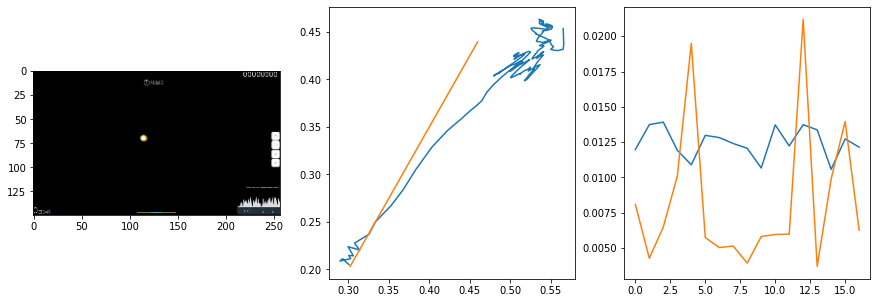

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.73it/s  0.0107                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

17 of 64
pred: 0.39696669578552246 0.4142304062843323
gt: 0.5340051054954529 0.5595927834510803
(130, 83)


<Figure size 1080x360 with 0 Axes>

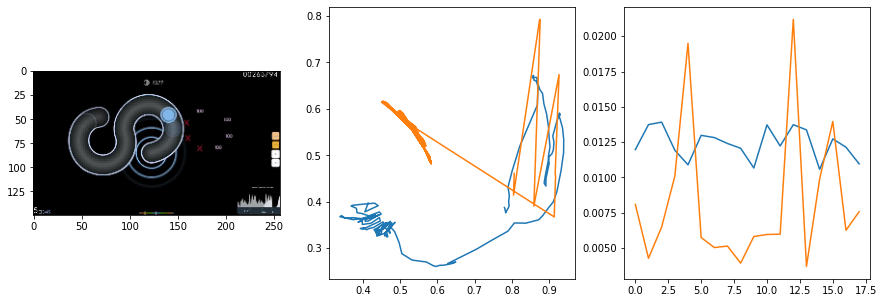

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.74it/s  0.0159                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

18 of 64
pred: 0.7091608643531799 0.662878692150116
gt: 0.6965082883834839 0.7909226417541504
(156, 109)


<Figure size 1080x360 with 0 Axes>

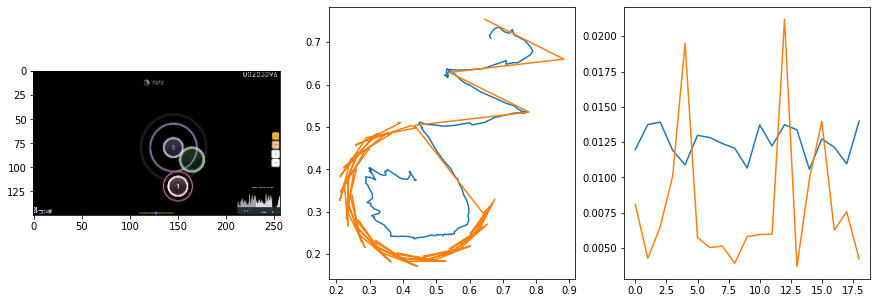

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.74it/s  0.0072                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

19 of 64
pred: 0.41419467329978943 0.7775933742523193
gt: 0.30181244015693665 0.7574915289878845
(94, 106)


<Figure size 1080x360 with 0 Axes>

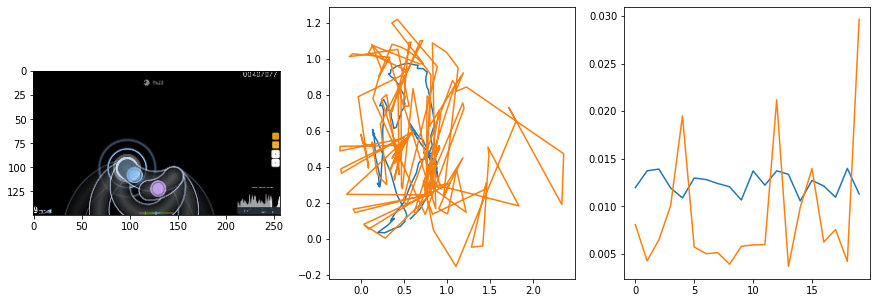

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.74it/s  0.0162                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

20 of 64
pred: 0.6150287985801697 0.5106251239776611
gt: 0.841463029384613 0.5018696188926697
(178, 76)


<Figure size 1080x360 with 0 Axes>

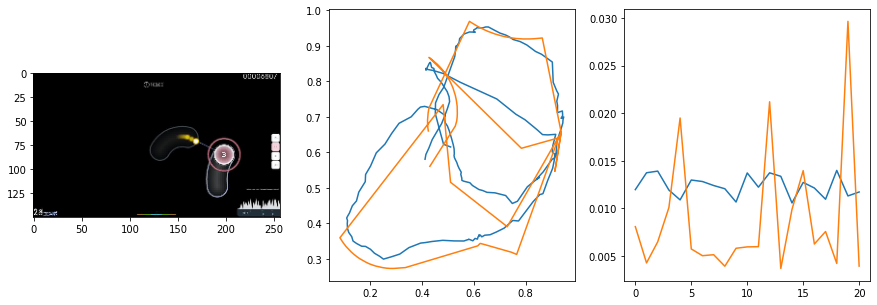

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.74it/s  0.0222                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

21 of 64
pred: 0.5382916331291199 0.4597327709197998
gt: 1.0519939661026 1.0066391229629517
(211, 135)


<Figure size 1080x360 with 0 Axes>

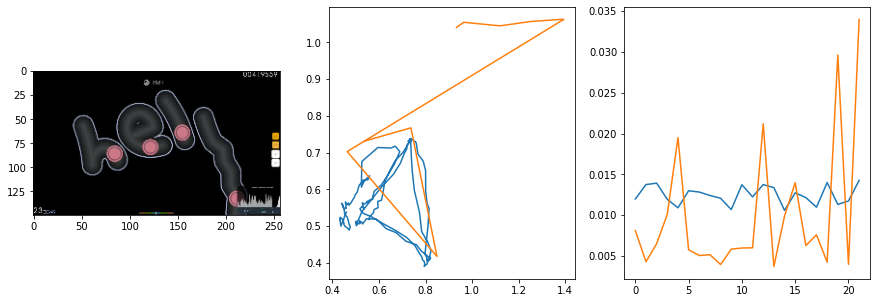

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.74it/s  0.0373                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

22 of 64
pred: 0.6029874086380005 0.6867774724960327
gt: 0.8569155335426331 0.7509644627571106
(180, 105)


<Figure size 1080x360 with 0 Axes>

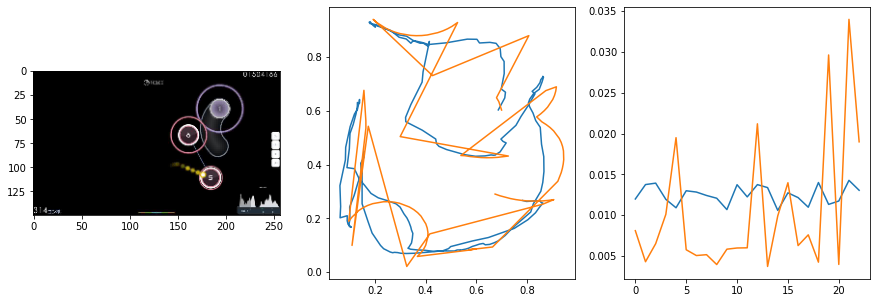

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.72it/s  0.0191                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

23 of 64
pred: 0.6937936544418335 0.4768754839897156
gt: 0.7752190232276917 0.6044138669967651
(168, 88)


<Figure size 1080x360 with 0 Axes>

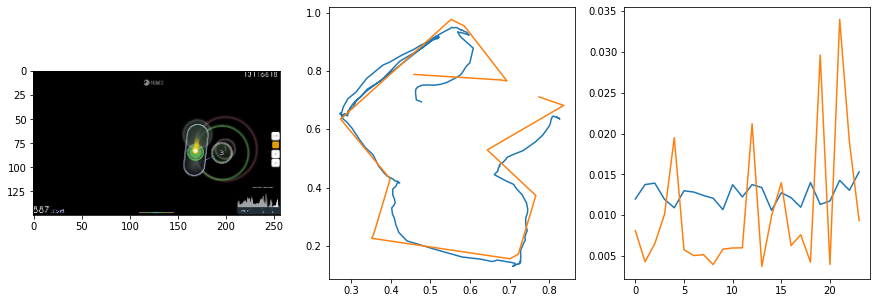

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.78it/s  0.0058                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

24 of 64
pred: 0.2891293168067932 0.6067258715629578
gt: 0.5360804200172424 0.7553420066833496
(131, 105)


<Figure size 1080x360 with 0 Axes>

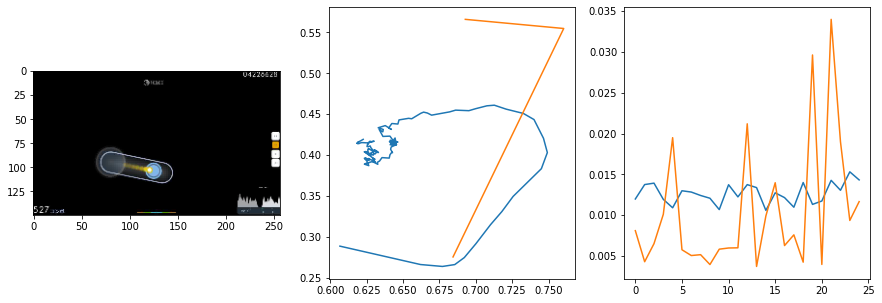

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.77it/s  0.0050                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

25 of 64
pred: 0.22299546003341675 0.6623783707618713
gt: 0.2300889790058136 0.5109230279922485
(83, 77)


<Figure size 1080x360 with 0 Axes>

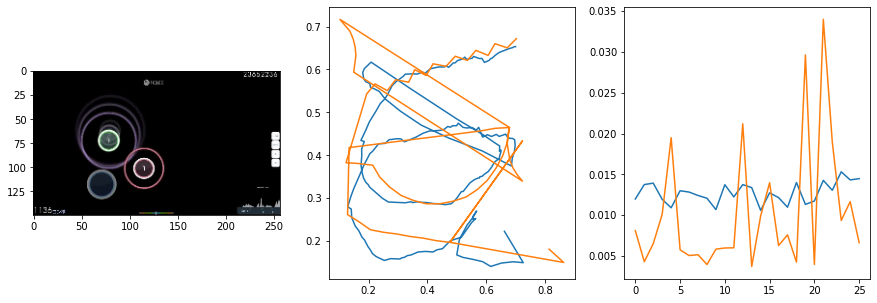

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.72it/s  0.0054                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

26 of 64
pred: 0.3719758093357086 0.27435290813446045
gt: 0.46484375 0.4427083432674408
(120, 69)


<Figure size 1080x360 with 0 Axes>

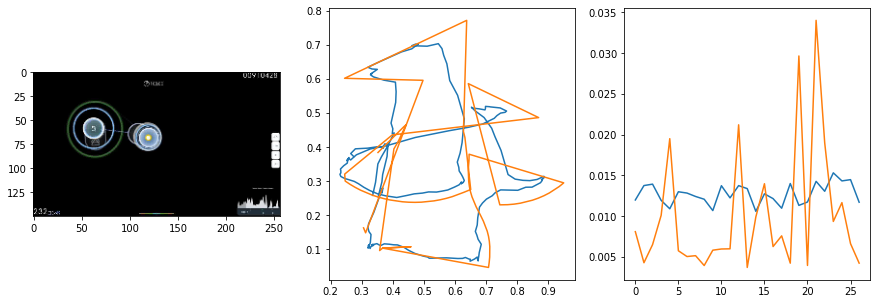

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.69it/s  0.0131                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

27 of 64
pred: 0.21833834052085876 0.34907931089401245
gt: 0.17539860308170319 0.3116142153739929
(75, 54)


<Figure size 1080x360 with 0 Axes>

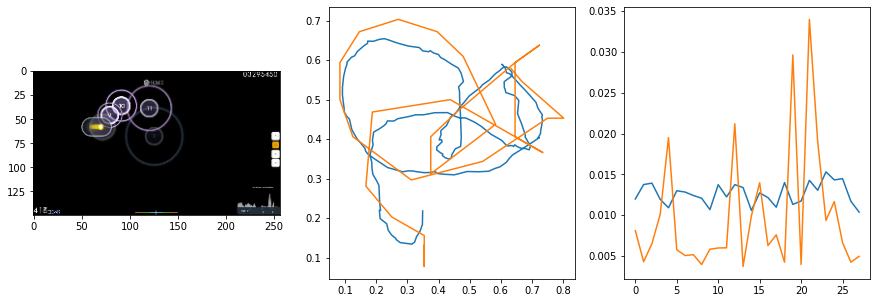

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.80it/s  0.0131                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

28 of 64
pred: 0.6494077444076538 0.6913268566131592
gt: 0.692187488079071 0.625
(155, 90)


<Figure size 1080x360 with 0 Axes>

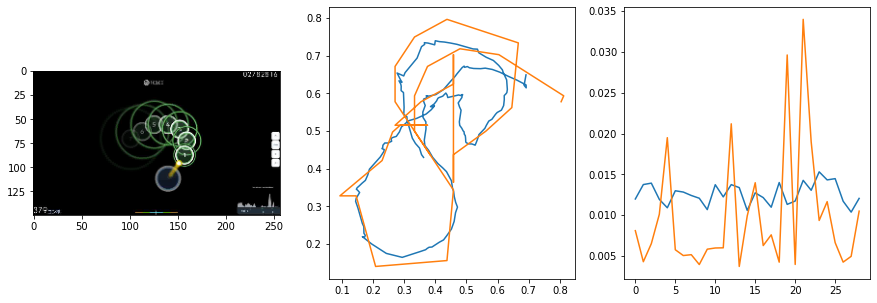

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.79it/s  0.0447                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

29 of 64
pred: 0.45706963539123535 0.26830005645751953
gt: 0.42331966757774353 0.3365860879421234
(113, 57)


<Figure size 1080x360 with 0 Axes>

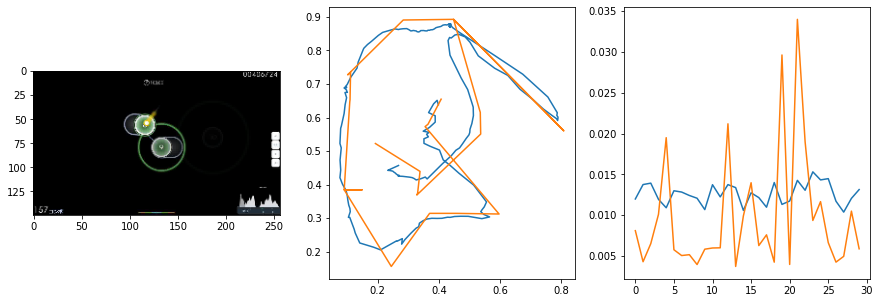

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.74it/s  0.0088                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

30 of 64
pred: 0.8422309160232544 0.5133215188980103
gt: 0.8548309803009033 0.5914646983146667
(180, 86)


<Figure size 1080x360 with 0 Axes>

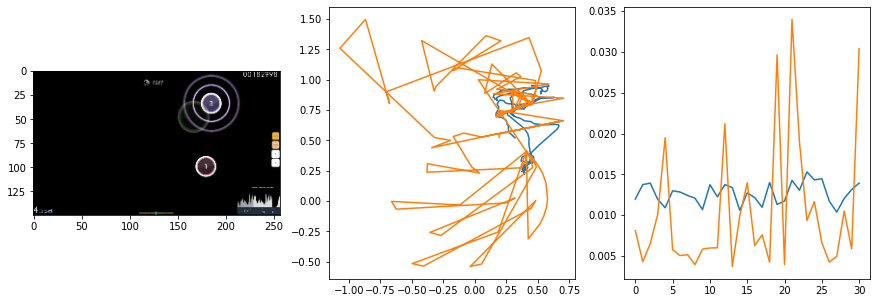

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.81it/s  0.0093                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

31 of 64
pred: 0.5420480370521545 0.2017243206501007
gt: 0.515625 0.203125
(127, 41)


<Figure size 1080x360 with 0 Axes>

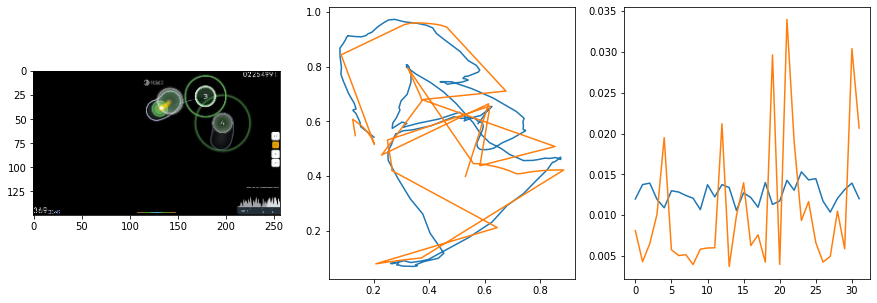

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.70it/s  0.0109                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

32 of 64
pred: 0.5704692006111145 0.6474412679672241
gt: 0.5625 0.4711221158504486
(135, 72)


<Figure size 1080x360 with 0 Axes>

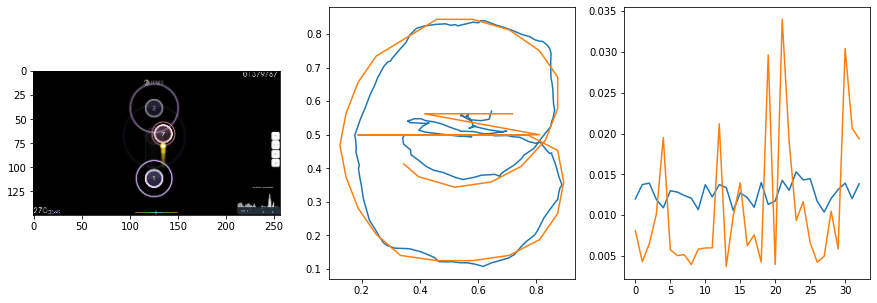

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.73it/s  0.0055                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

33 of 64
pred: 0.5952980518341064 0.6755094528198242
gt: 0.4565354585647583 0.7031917572021484
(118, 99)


<Figure size 1080x360 with 0 Axes>

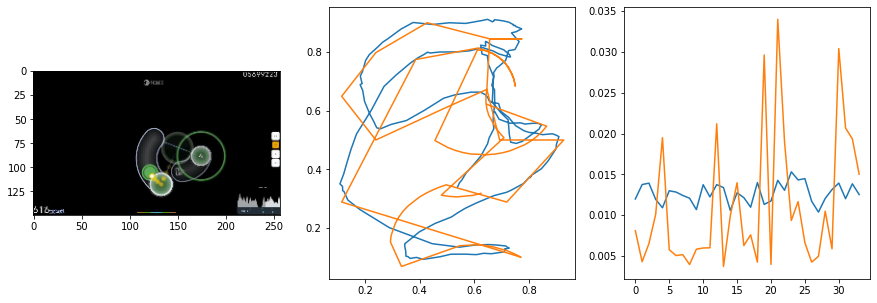

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.74it/s  0.0111                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

34 of 64
pred: 0.4372290074825287 0.5184914469718933
gt: 0.4016069173812866 0.6684431433677673
(110, 95)


<Figure size 1080x360 with 0 Axes>

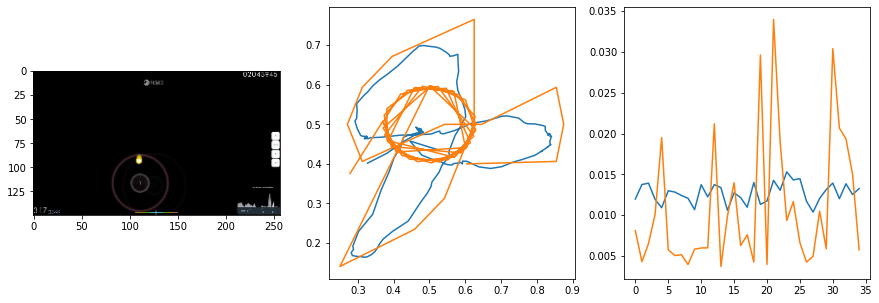

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.73it/s  0.0296                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

35 of 64
pred: 0.4948985278606415 0.786787748336792
gt: 0.58203125 0.765625
(138, 107)


<Figure size 1080x360 with 0 Axes>

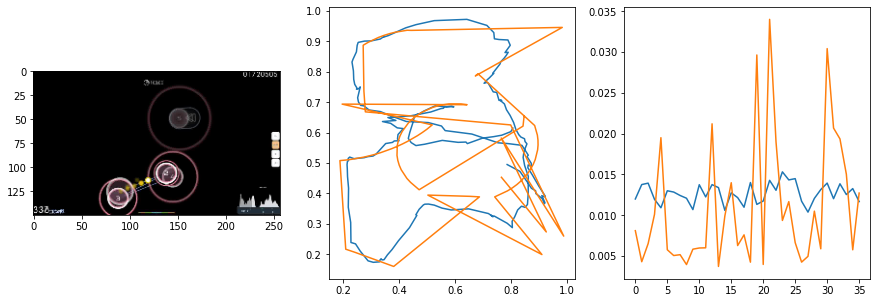

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.71it/s  0.0122                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

36 of 64
pred: 0.4804583787918091 0.46901795268058777
gt: 0.5609742403030396 0.7223150730133057
(134, 102)


<Figure size 1080x360 with 0 Axes>

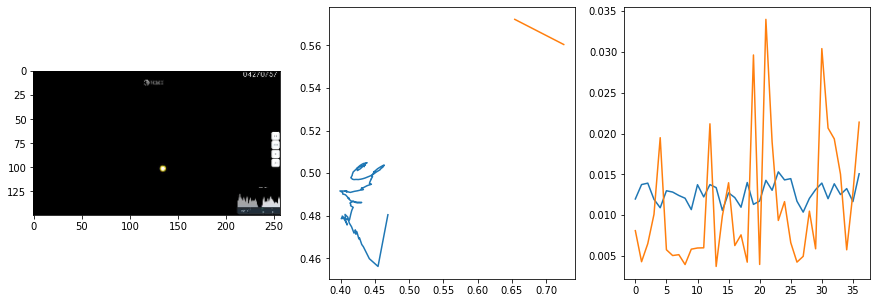

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.73it/s  0.0114                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

37 of 64
pred: 0.32051315903663635 0.6500382423400879
gt: 0.27236127853393555 0.6781993508338928
(90, 96)


<Figure size 1080x360 with 0 Axes>

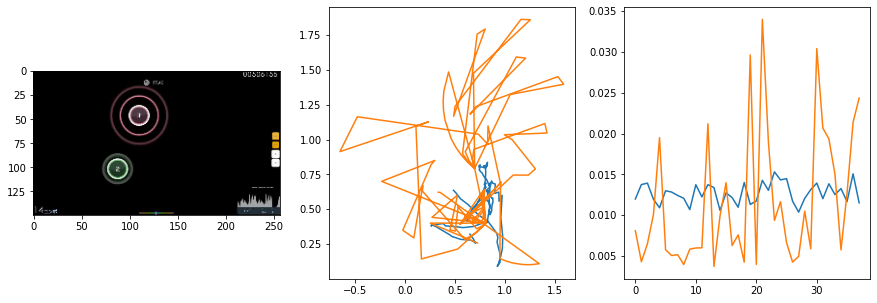

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.74it/s  0.0067                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

38 of 64
pred: 0.6499230861663818 0.49873489141464233
gt: 0.5017321705818176 0.39368000626564026
(125, 63)


<Figure size 1080x360 with 0 Axes>

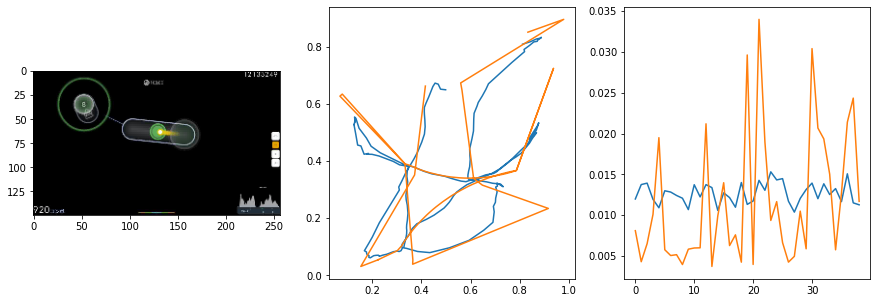

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.79it/s  0.0079                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

39 of 64
pred: 0.2179456204175949 0.36722850799560547
gt: 0.1038752943277359 0.375340074300766
(64, 61)


<Figure size 1080x360 with 0 Axes>

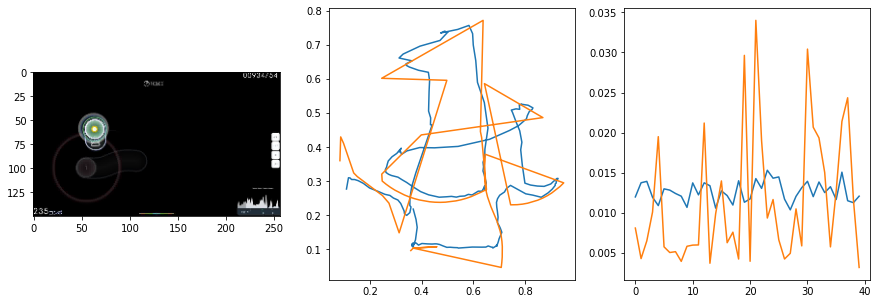

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.79it/s  0.0072                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

40 of 64
pred: 0.527450680732727 0.5828492045402527
gt: 0.5885955095291138 0.7820441722869873
(139, 108)


<Figure size 1080x360 with 0 Axes>

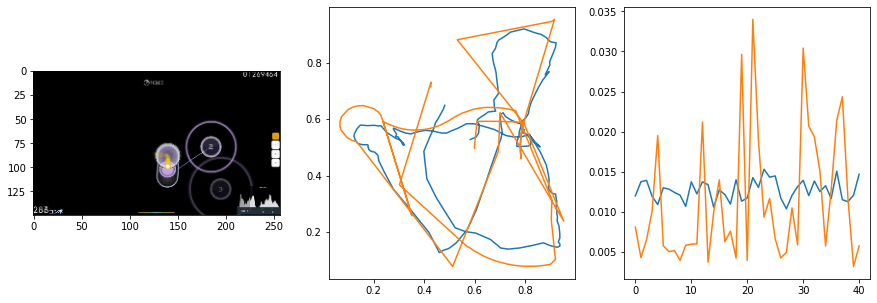

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.74it/s  0.0047                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

41 of 64
pred: 0.5900622606277466 0.5118553042411804
gt: 0.73046875 0.4791666567325592
(161, 73)


<Figure size 1080x360 with 0 Axes>

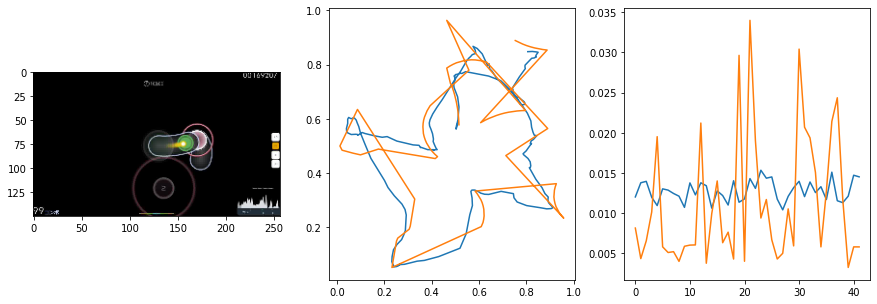

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.72it/s  0.0058                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

42 of 64
pred: 0.5136182308197021 0.6572681665420532
gt: 0.3643818795681 0.6835810542106628
(104, 97)


<Figure size 1080x360 with 0 Axes>

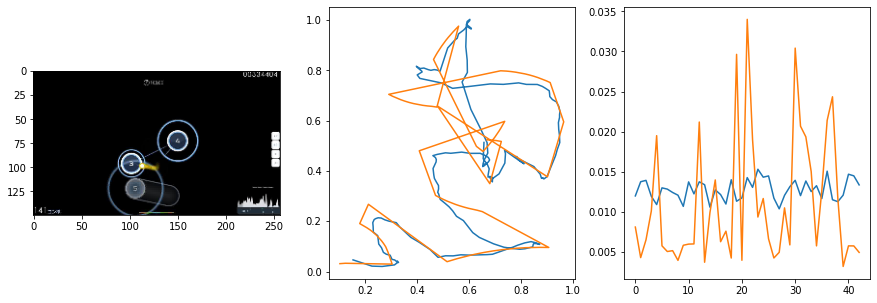

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.69it/s  0.0131                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

43 of 64
pred: 0.17441463470458984 0.6198161244392395
gt: 0.08756732940673828 0.29210570454597473
(61, 51)


<Figure size 1080x360 with 0 Axes>

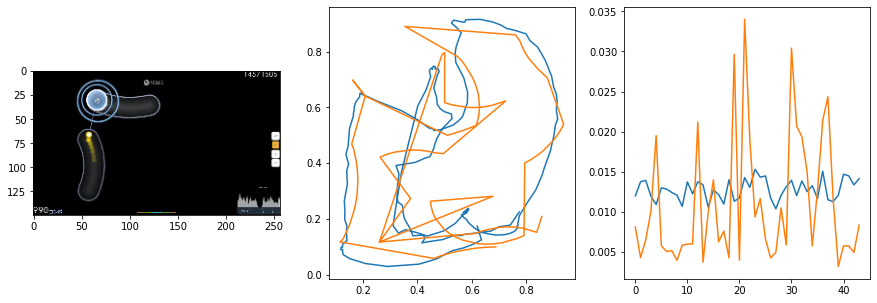

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.69it/s  0.0173                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

44 of 64
pred: 0.7533209919929504 0.3606121838092804
gt: 0.8786430954933167 0.4529878795146942
(184, 70)


<Figure size 1080x360 with 0 Axes>

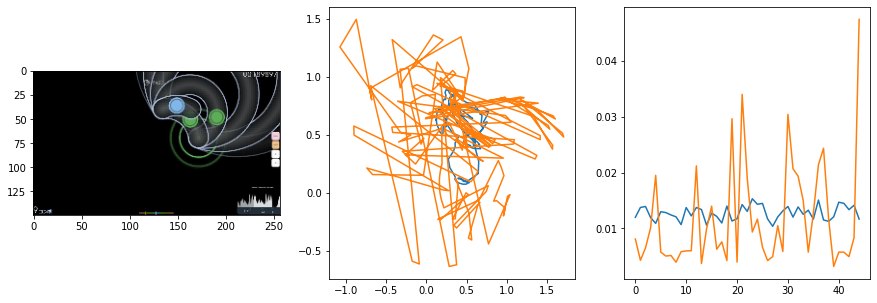

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.70it/s  0.0041                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

45 of 64
pred: 0.42781180143356323 0.5198431015014648
gt: 0.42784029245376587 0.5600370764732361
(114, 83)


<Figure size 1080x360 with 0 Axes>

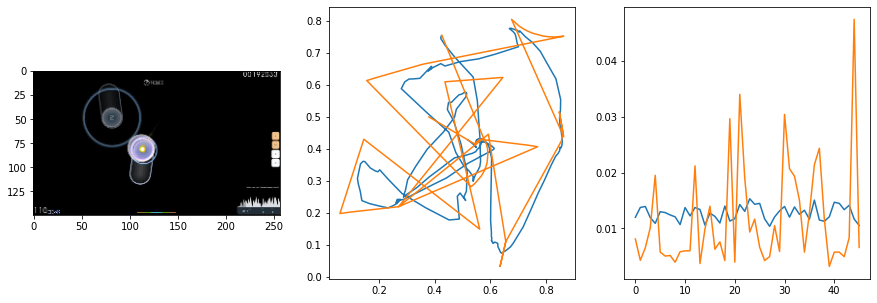

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.74it/s  0.0057                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

46 of 64
pred: 0.7934852838516235 0.5265990495681763
gt: 0.3865581750869751 0.23276685178279877
(107, 45)


<Figure size 1080x360 with 0 Axes>

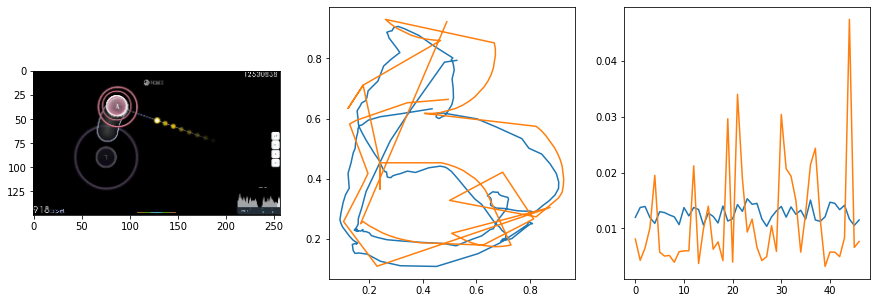

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.72it/s  0.0066                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

47 of 64
pred: 0.7877473831176758 0.5020902752876282
gt: 0.8659244775772095 0.3720439374446869
(182, 61)


<Figure size 1080x360 with 0 Axes>

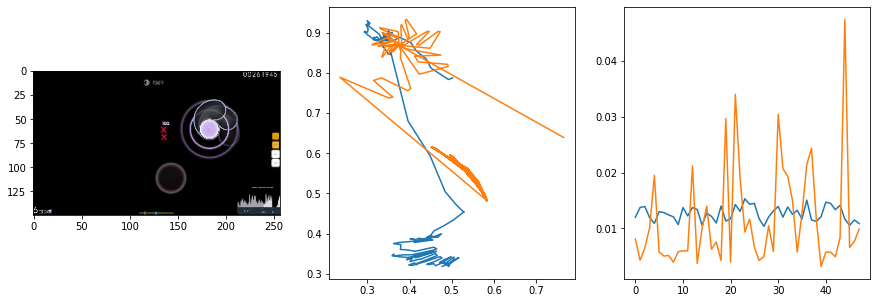

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.73it/s  0.0123                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

48 of 64
pred: 0.49270889163017273 0.284259557723999
gt: 0.5940688848495483 0.3460884392261505
(140, 58)


<Figure size 1080x360 with 0 Axes>

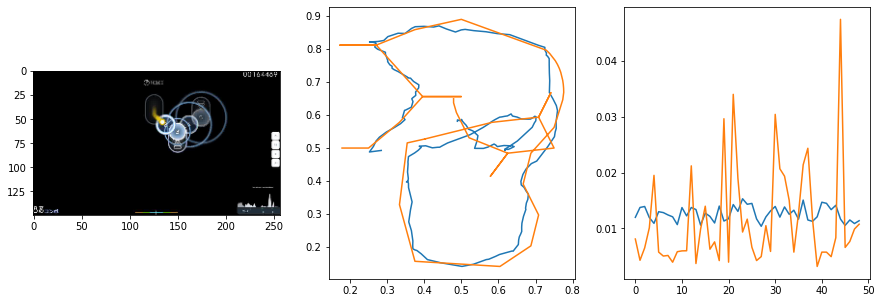

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.74it/s  0.0219                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

49 of 64
pred: 0.5285220146179199 0.6273118853569031
gt: 0.32018786668777466 0.25141727924346924
(97, 47)


<Figure size 1080x360 with 0 Axes>

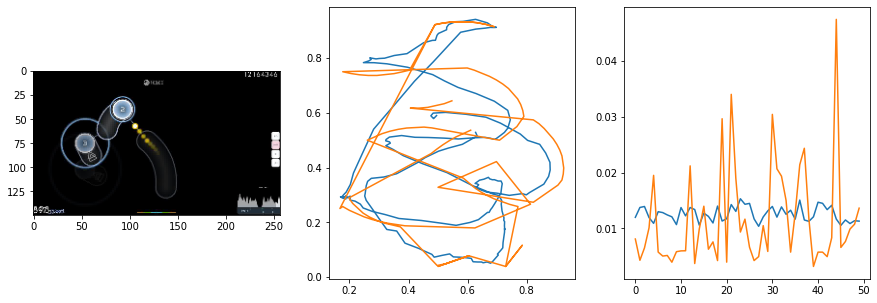

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.74it/s  0.0311                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

50 of 64
pred: 0.24559229612350464 0.7665376663208008
gt: 0.373046875 0.6666666865348816
(105, 95)


<Figure size 1080x360 with 0 Axes>

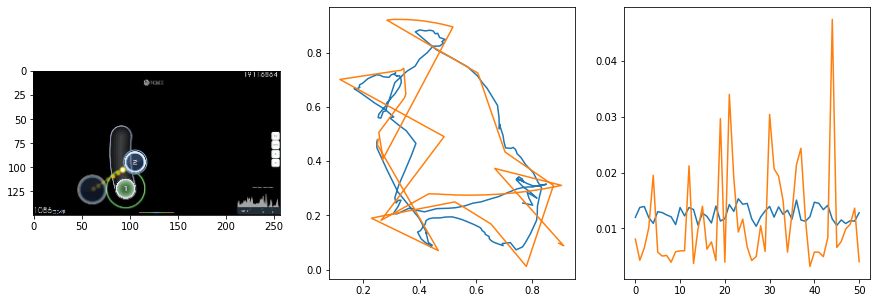

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.73it/s  0.0062                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

51 of 64
pred: 0.5342057943344116 0.5939587354660034
gt: 0.46249234676361084 0.44998130202293396
(119, 70)


<Figure size 1080x360 with 0 Axes>

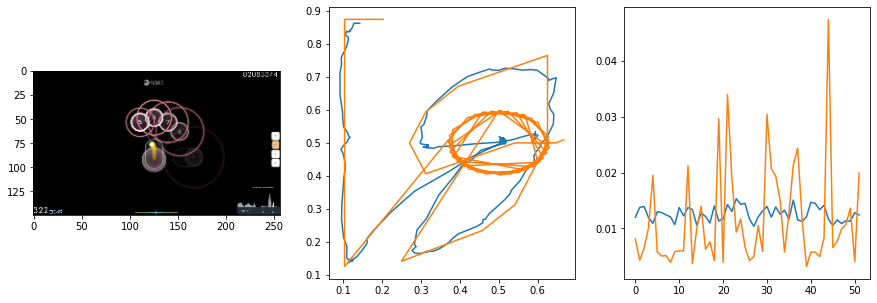

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.74it/s  0.0197                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

52 of 64
pred: 0.43681180477142334 0.7792885303497314
gt: 0.4576602280139923 0.9560381770133972
(118, 129)


<Figure size 1080x360 with 0 Axes>

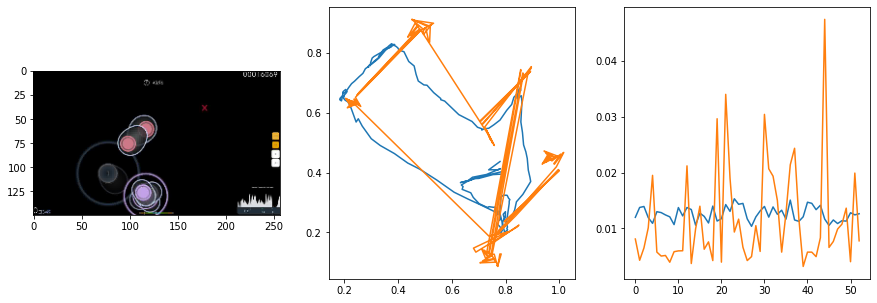

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.72it/s  0.0136                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

53 of 64
pred: 0.6888565421104431 0.6975066065788269
gt: 0.783203125 0.7057291865348816
(169, 100)


<Figure size 1080x360 with 0 Axes>

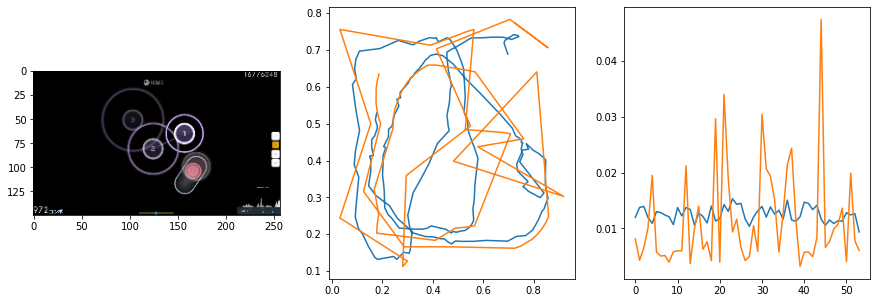

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.72it/s  0.0154                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

54 of 64
pred: 0.719258189201355 0.5718047618865967
gt: 0.662109375 0.5520833134651184
(150, 82)


<Figure size 1080x360 with 0 Axes>

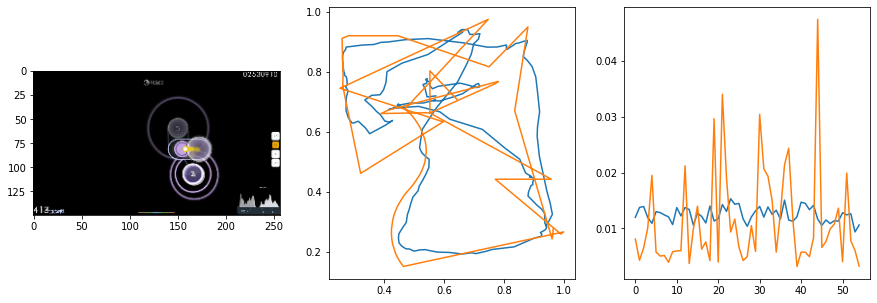

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.72it/s  0.0059                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

55 of 64
pred: 0.826295793056488 0.5374429225921631
gt: 0.8420758843421936 0.6121917366981506
(178, 89)


<Figure size 1080x360 with 0 Axes>

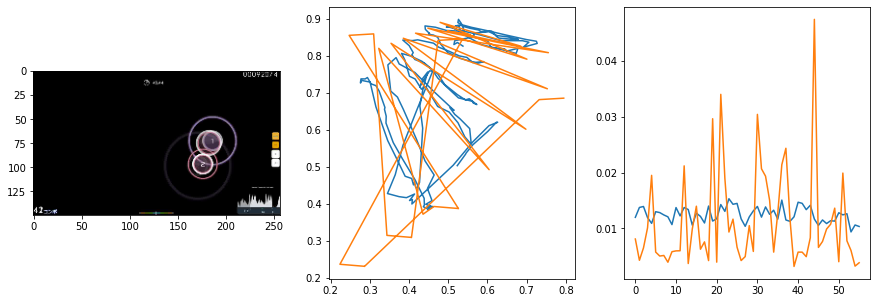

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.71it/s  0.0114                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

56 of 64
pred: 0.4793463945388794 0.47131988406181335
gt: 0.3953767716884613 0.3058813810348511
(109, 53)


<Figure size 1080x360 with 0 Axes>

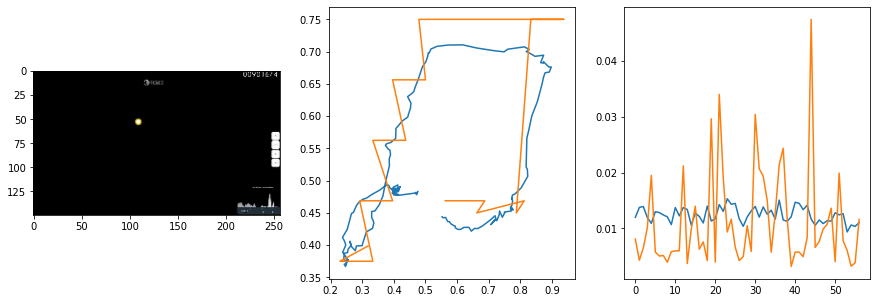

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.71it/s  0.0038                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

57 of 64
pred: 0.37228962779045105 0.6147527098655701
gt: 0.296875 0.9322916865348816
(94, 126)


<Figure size 1080x360 with 0 Axes>

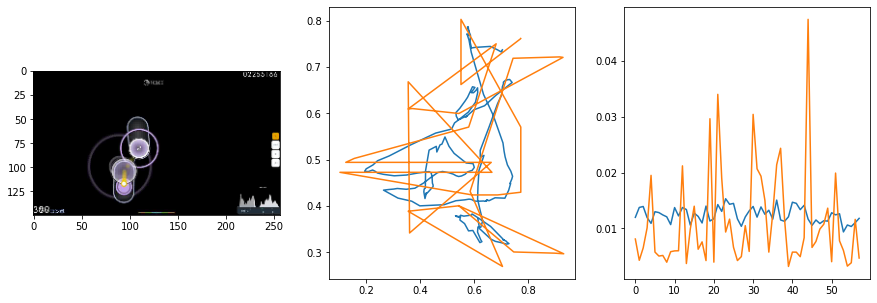

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.74it/s  0.0049                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

58 of 64
pred: 0.2534048855304718 0.6369115710258484
gt: 0.5573863983154297 0.8696280121803284
(134, 119)


<Figure size 1080x360 with 0 Axes>

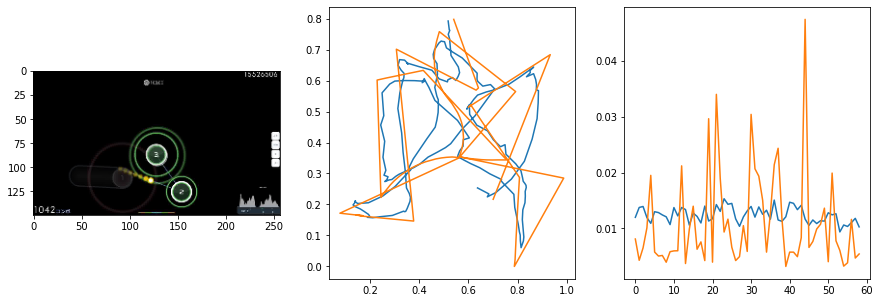

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.74it/s  0.0036                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

59 of 64
pred: 0.6542839407920837 0.506130576133728
gt: 0.7500989437103271 0.31987234950065613
(164, 55)


<Figure size 1080x360 with 0 Axes>

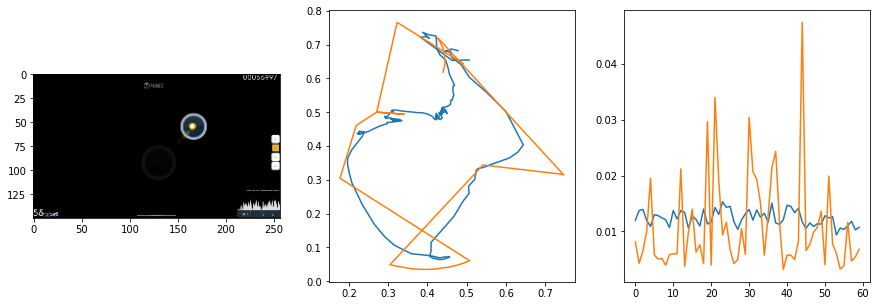

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.73it/s  0.0112                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

60 of 64
pred: 0.9216159582138062 0.3309316039085388
gt: 0.7214796543121338 0.2930499315261841
(159, 52)


<Figure size 1080x360 with 0 Axes>

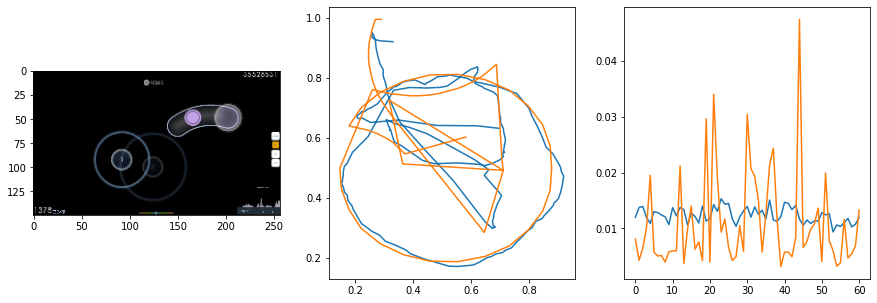

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.73it/s  0.0093                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

61 of 64
pred: 0.4234778583049774 0.5178879499435425
gt: 0.6755514740943909 0.5
(152, 76)


<Figure size 1080x360 with 0 Axes>

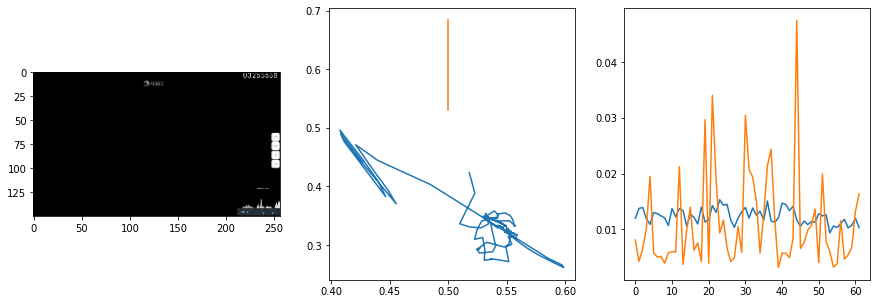

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.75it/s  0.0044                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

62 of 64
pred: 0.583215594291687 0.4097803235054016
gt: 0.755859375 0.3932291567325592
(165, 63)


<Figure size 1080x360 with 0 Axes>

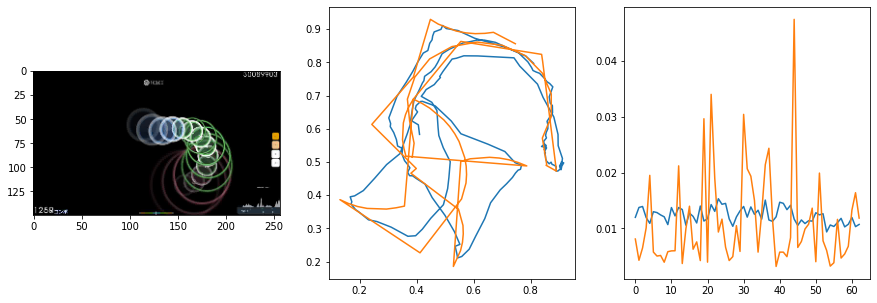

 Iters    Elapsed Time      Speed     loss                                      
 13/13  00:00:07<00:00:00  1.79it/s  0.0086                                     

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

63 of 64
pred: 0.6923715472221375 0.6855506896972656
gt: 0.6471151113510132 0.7181524634361267
(148, 101)


<Figure size 1080x360 with 0 Axes>

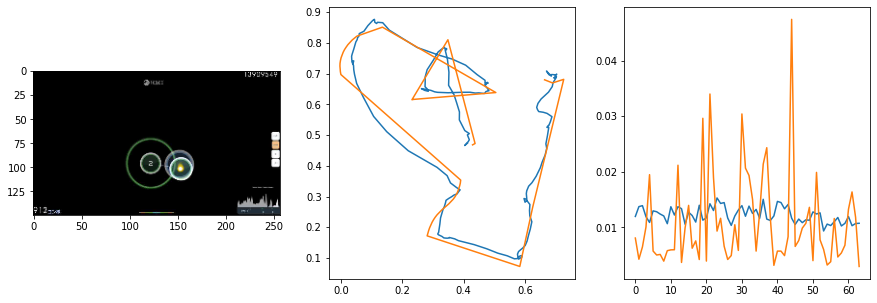

633.4024229049683 secs


In [ ]:
start = time.time()

lamb = 3
epochs = 64
trainVN()

end = time.time()
print(end - start, 'secs')

In [ ]:
torch.save(vn.state_dict(), model_path + str(epoch_cum) + '.pt')

# Test Model

In [ ]:
import os
import cv2
import torch
import torchvision.transforms as transforms

In [ ]:
vn.load_state_dict(torch.load(model_path + str(128) + '.pt'))

<All keys matched successfully>

In [ ]:
#osud = '../ex/beatmaps/567301 LamazeP - Spam Jack'
#osuf = 'LamazeP - Spam Jack (OsuToothbrush) [SPAM].osu'
#osud = '../ex/beatmaps/252981 DJ Okawari - Flower Dance (Short Ver)'
#osuf = 'DJ Okawari - Flower Dance (Short Ver.) (-Hanayuki-) [Relax].osu'
#osud = '../ex/beatmaps/348381 sasakureUK - Spider Thread Monopoly feat Hatsune Miku'
#osuf = 'sasakure.UK - Spider Thread Monopoly feat. Hatsune Miku (Mishima Yurara) [Milan-\'s Hard].osu'
#osud = '../demo/beatmaps/835194 Mili - Vulnerability'
#osuf = 'Mili_-_Vulnerability_IceKalt_Saturnalizes_Insane.osu'
#osud = '../demo/beatmaps/653534 Panda Eyes - ILY'
#osuf = 'Panda Eyes - ILY (M a r v o l l o) [Light Insane].osu'
osud = '../demo/beatmaps/388036 Akiyama Uni - Kanpan Tasogare Shinbun'
osuf = 'Akiyama Uni - Kanpan Tasogare Shinbun (09kami) [Insane].osu'

In [ ]:
osr = OSR(osud, osuf, sample_rate=sample_rate, hop_size=hop_size, skin='./skin_hidden', vtmp='../demo/vids/')

In [ ]:
osr.create_vid()

***********************************************************
['ffmpeg', '-y', '-loglevel', 'info', '-thread_queue_size', '24', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1024x600', '-pix_fmt', 'yuv420p', '-r', '50.00', '-an', '-i', '-', '-i', '/tmp/06243aac-b4d3-11ec-b0b0-a85e4554c351temp/audio.mp3', '-acodec', 'aac', '-vcodec', 'mjpeg', '-preset', 'fast', '-crf', '18', '-ab', '320k', '-threads', '0', '../demo/vids/Akiyama Uni - Kanpan Tasogare Shinbun (09kami) [Insane].osu.avi']
***********************************************************


In [ ]:
video_path = os.path.join('../demo/vids/', osuf + '.avi')

In [ ]:
vn.to(device)
vn.init_hidden(1)
vn.eval()

VN(
  (convA): Conv2d(3, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (convB): Conv2d(1, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (linear1): Linear(in_features=2368, out_features=592, bias=True)
  (lstmA): LSTM(592, 64, num_layers=2, batch_first=True)
  (linearA): Linear(in_features=64, out_features=32, bias=True)
  (linearB): Linear(in_features=32, out_features=2, bias=True)
)

In [ ]:
transform = transforms.ToTensor()
frames = []
vc = cv2.VideoCapture(video_path)
p = []
while True:
    r, f = vc.read()
    if r is False:
        break
    f = cv2.resize(f, (0,0), fx=scale, fy=scale)
    F = transform(f).to(device)
    with torch.no_grad():
        P = vn(F.unsqueeze(0).unsqueeze(0))
    p.append(P.squeeze(0).squeeze(0).cpu().detach().numpy())

# Create Replay Video

In [ ]:
from IPython.display import Video

In [ ]:
np.save('predVN.npy', p)

In [ ]:
eosud = osud.replace('/', '\/')

In [ ]:
!sed -i "s/Beatmap path.*/Beatmap path\": \"$eosud\/$osuf\",/" data.json
!sed -i "s/Output path.*/Output path\": \"videoVN.mp4\",/" data.json

In [ ]:
!python create_replayVN.py predVN.npy 50

2022-04-05 07:25:26,872:INFO:osr2mp4.Osr2mp4:__init__:test
2022-04-05 07:25:26,873:TRACE:osr2mp4.Utils.Setup:setupglobals:CALL *({'osu! path': '', 'Skin path': 'skin/', 'Beatmap path': '../demo/beatmaps/388036 Akiyama Uni - Kanpan Tasogare Shinbun/Akiyama Uni - Kanpan Tasogare Shinbun (09kami) [Insane].osu', '.osr path': 'auto', 'Default skin path': 'skin/', 'Output path': 'videoVN.mp4', 'Width': 1024, 'Height': 600, 'FPS': 30, 'Start time': 0, 'End time': -1, 'Video codec': 'mjpeg', 'Process': 0, 'ffmpeg path': 'ffmpeg'}, {'Show score meter': True, 'Always show key overlay': True, 'Song volume': 100, 'Effect volume': 100, 'Enable PP counter': True, 'Enable Strain Graph': True, 'FFmpeg codec': 'libx264', 'FFmpeg custom commands': '', 'Audio bitrate': 320, 'api key': None, 'Use FFmpeg video writer': True, 'Custom mods': ''}, [], <osr2mp4.global_var.Settings object at 0x7f3404db3550>) **{'ppsettings': {'x': 1220, 'y': 690, 'text_x': 1140, 'text_y': 748, 'Font Size': 20, 'Size': 10, 'Rgb'

In [ ]:
Video("videoVN.mp4")

In [ ]:
!sed -i "s/Output path.*/Output path\": \"video.mp4\",/" data.json

In [ ]:
!python create_replay.py predHN.npy predVN.npy 50 0.5

2022-04-05 01:28:27,439:INFO:osr2mp4.Osr2mp4:__init__:test
2022-04-05 01:28:27,439:TRACE:osr2mp4.Utils.Setup:setupglobals:CALL *({'osu! path': '', 'Skin path': 'skin/', 'Beatmap path': "../ex/beatmaps/348381 sasakureUK - Spider Thread Monopoly feat Hatsune Miku/sasakure.UK - Spider Thread Monopoly feat. Hatsune Miku (Mishima Yurara) [Milan-'s Hard].osu", '.osr path': 'auto', 'Default skin path': 'skin/', 'Output path': 'video.mp4', 'Width': 1024, 'Height': 600, 'FPS': 30, 'Start time': 0, 'End time': -1, 'Video codec': 'mjpeg', 'Process': 0, 'ffmpeg path': 'ffmpeg'}, {'Show score meter': True, 'Always show key overlay': True, 'Song volume': 100, 'Effect volume': 100, 'Enable PP counter': True, 'Enable Strain Graph': True, 'FFmpeg codec': 'libx264', 'FFmpeg custom commands': '', 'Audio bitrate': 320, 'api key': None, 'Use FFmpeg video writer': True, 'Custom mods': ''}, [], <osr2mp4.global_var.Settings object at 0x7f5a2cedf580>) **{'ppsettings': {'x': 1220, 'y': 690, 'text_x': 1140, 'tex

In [ ]:
Video("video.mp4")